In [31]:
import csv
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from collections import defaultdict

df2 = pd.read_csv('BERT_PREDICTIONS.csv')

df3 = pd.read_csv('df_with_moral_embeddings.csv')

#making sure that the columns for analysis from previous analyses are in the correct format/have the correct labels.
# This function recodes any of the foundation which could be labelled as 2,3,5 (the categories which are not being assess due to rareity are removed)
def recode_moral(value):
    if value in [2, 3, 5]:
        return 6
    else:
        return value

# Apply the custom function to create the 'recoded' column
df2['recoded'] = df2['moral_mf_single'].apply(recode_moral)
#df2.head()

df3['recoded'] = df3['moral_mf_single'].apply(recode_moral)
#df3.head(20)

In [32]:
#here I am creating the foreign secretaries subset for df3 (the dataset which has the word embedding assigned labels contrained within it)

#this is the list of all foreign secretaries contained in the dataset. 
mps_to_filter = [
    'James Cleverly', 'Elizabeth Truss', 'Dominic Raab', 'Jeremy Hunt', 'Boris Johnson',
    'Philip Hammond', 'William Hague', 'David Miliband', 'Margaret Beckett', 'Jack Straw',
    'Robin Cook', 'Malcolm Rifkind', 'Douglas Hurd', 'John Major', 'Geoffrey Howe'
]

filtered_df = df3[df3['speaker2'].isin(mps_to_filter)]

# filtering for references said by foreign secretaries based of off the year that they they were foreign secretary in
#list of foreign secretarie tenures was gained using wikipedia.
foreign_secretary_tenures = {
    'James Cleverly': (2022, 2023),
    'Elizabeth Truss': (2021, 2022),
    'Dominic Raab': (2019, 2021),
    'Jeremy Hunt': (2018, 2019),
    'Boris Johnson': (2016, 2018),
    'Philip Hammond': (2014, 2016),
    'William Hague': (2010, 2014),
    'David Miliband': (2007, 2010),
    'Margaret Beckett': (2006, 2007),
    'Jack Straw': (2001, 2006),
    'Robin Cook': (1997, 2001),
    'Malcolm Rifkind': (1995, 1997),
    'Douglas Hurd': (1989, 1995),
    'John Major': (1989, 1989), 
    'Geoffrey Howe': (1983, 1989)
}

filtered_sentences_df1 = pd.DataFrame()

# This block of code iterates over each of the foriegn secretaries based on their year range.  
for mp, year_range in foreign_secretary_tenures.items():
    start_year, end_year = year_range[0], year_range[1]
    mp_sentences = filtered_df[(filtered_df['speaker2'] == mp) & (filtered_df['Year'] >= start_year) & (filtered_df['Year'] <= end_year)]
    filtered_sentences_df1 = pd.concat([filtered_sentences_df1, mp_sentences])

#counting the references per foreign secretaries (it should be references not sentences in the name - however I have carried this typo 
#through all the code in this section, hence it remains).
sentences_per_foreign_secretary = filtered_sentences_df1.groupby('speaker2').size().reset_index(name='Number_of_references')

filtered_sentences_df1.head()

,Unnamed: 0.1,Unnamed: 0,Reference to China,speaker2,speech_id,speechnumber,party2,agenda,date2,Year,...,multiple_mf_dict,moral_words_flagged,moral_mf_single,moral_sentiment,Reconstruction Loss,predicted_labels2,predicted_labels,moral_embeddings,moral_embeddings2,recoded
15050,NaN,15168,the sinobritish joint declaration is a legally...,James Cleverly,2095146,NaN,Con,NaN,12/05/2022,2022,...,"1, 4, 5","protect, protect, religion",1,1,0.000878,1,4,2,4,1
15051,NaN,15169,it is not for me to give advice to the governm...,James Cleverly,2095151,NaN,Con,NaN,12/05/2022,2022,...,0,NaN,0,0,0.000586,2,6,1,6,0
15052,NaN,15170,he is right to highlight that what is happenin...,James Cleverly,2095153,NaN,Con,NaN,12/05/2022,2022,...,5,religion,5,1,0.000413,1,6,1,1,6
15172,NaN,15307,those friendships and partnerships are a good ...,James Cleverly,2144702,NaN,Con,NaN,13/03/2023,2023,...,0,NaN,0,0,0.000871,1,6,1,0,0
15174,NaN,15309,secondly we must ensure that in doing so we do...,James Cleverly,2144706,NaN,Con,NaN,13/03/2023,2023,...,4,leaders,4,1,0.000607,1,6,1,6,4


NOTE: much of the following code is essentially, the same initial block of code repeated again and again to calculate proportions for different models for both moral sentiment and moral foundations. So, the dataframe names change, the names of the columns and the labels themsevles namely either 0,1,2 or 0,1,4,6 but the structure of the code is identicial.

the code for the standard errors/ confidence intervals and z-scores are adapted from these sources: 
https://stats.stackexchange.com/questions/467303/calculating-the-standard-error-and-confidence-interval-for-cohens-quadratic-kap
https://stackoverflow.com/questions/53519823/confidence-interval-in-python-dataframe
https://rowannicholls.github.io/python/statistics/confidence_intervals.html
https://python-code.dev/articles/3736
https://datagy.io/python-z-score/
https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data

In [38]:
#THIS CODE IS FOR CALCULATING THE PROPORTIONS FOR THE DISTILEBRT MODEL FOR MORAL FOUNDATION CATEGORIES. 
#IT COMPARES THE PROPRTIONS FOR ALL MPS TO ALL FOREIGN SECRETARIES.
import scipy.stats as stats
# Calculating proportions for each foundation 
proportions_conservative = {}
proportions_labour = {}

for foundation in [0, 1, 4, 6]:
    foundation_texts_all = df2[df2['predicted_labels'] == foundation]
    foundation_texts_fs = filtered_sentences_df1[filtered_sentences_df1['predicted_labels'] == foundation]

    proportion_con = len(foundation_texts_all) / len(df2) if len(df2) > 0 else 0.0
    proportion_lab = len(foundation_texts_fs) / len(filtered_sentences_df1) if len(filtered_sentences_df1) > 0 else 0.0

    proportions_conservative[foundation] = proportion_con
    proportions_labour[foundation] = proportion_lab

#setting a level for alpha to compare the p-values to, first it was set at 0.05, although I also looked at the values of alpha 0.01 and 0.1.
alpha = 0.05

for foundation in [0, 1, 4, 6]:
    print(f"Moral Foundation {foundation}")
    print(f"Proportion of All MPs Texts: {proportions_conservative[foundation]}")
    print(f"Proportion of foreign sec Texts: {proportions_labour[foundation]}")

    #these lines of code are used to calculate the upper and lower bounds for 95% confident intervales
    se_con = np.sqrt(proportions_conservative[foundation] * (1 - proportions_conservative[foundation]) / len(df3))
    se_lab = np.sqrt(proportions_labour[foundation] * (1 - proportions_labour[foundation]) / len(filtered_sentences_df1))

    ci_con = (proportions_conservative[foundation] - 1.96 * se_con, proportions_conservative[foundation] + 1.96 * se_con)
    ci_lab = (proportions_labour[foundation] - 1.96 * se_lab, proportions_labour[foundation] + 1.96 * se_lab)

    print(f"Confidence Interval: {ci_con}")
    print(f"Confidence Interval: {ci_lab}")
    print()
#this code is calculating the pooled proportions and the z-scores, and then finally the p-values.
    p1 = proportions_labour[foundation]
    p2 = proportions_conservative[foundation]
    n1 = len(filtered_sentences_df1)
    n2 = len(df2)

    pooled_proportion = (p1 * n1 + p2 * n2) / (n1 + n2)
    standard_error = np.sqrt(pooled_proportion * (1 - pooled_proportion) * (1/n1 + 1/n2))
    z_score = (p1 - p2) / standard_error
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score))) #this was calcualted manually throughout the code as I had issues
    #with getting proprotions that summed up correctly/were dividing by the right thing when using automatic stats api calculations
    #for the confidence intervals ans the proportions.

    print(f"Z-Score: {z_score}")
    print(f"P-Value: {p_value}")
#this code determines whether the p-value is significant or not.
    if p_value <= alpha:
        print("Difference is statistically significant.")
    else:
        print("Difference is not statistically significant.")

    if z_score > 0:
        print("Foreign secs have a higher proportion.")
    else:
        print("All MPs have a higher proportion.")

    print()

Moral Foundation 0
Proportion of All MPs Texts: 0.5728947368421052
Proportion of foreign sec Texts: 0.5268630849220104
Confidence Interval: (0.5650308156026387, 0.5807586580815718)
Confidence Interval: (0.4861240753010286, 0.5676020945429923)

Z-Score: -2.192976520529989
P-Value: 0.028309070795442093
Difference is statistically significant.
All MPs have a higher proportion.

Moral Foundation 1
Proportion of All MPs Texts: 0.1456578947368421
Proportion of foreign sec Texts: 0.08145580589254767
Confidence Interval: (0.140049776039971, 0.15126601343371318)
Confidence Interval: (0.05913657549347138, 0.10377503629162396)

Z-Score: -4.320128838092613
P-Value: 1.5593813087022568e-05
Difference is statistically significant.
All MPs have a higher proportion.

Moral Foundation 4
Proportion of All MPs Texts: 0.07828947368421052
Proportion of foreign sec Texts: 0.14558058925476602
Confidence Interval: (0.07401892932079934, 0.0825600180476217)
Confidence Interval: (0.1168029307738073, 0.17435824773

In [37]:
import numpy as np
#THIS CODE IS FOR CALCULATING THE PROPORTIONS FOR THE CUSTOMISED DICTIONARY MODEL FOR MORAL FOUNDATION CATEGORIES. 
#IT COMPARES THE PROPRTIONS FOR ALL MPS TO ALL FOREIGN SECRETARIES.

# Calculating proportions for each foundation 
proportions_conservative = {}
proportions_labour = {}

for foundation in [0, 1, 4, 6]:
    foundation_texts_all = df2[df2['recoded'] == foundation]
    foundation_texts_fs = filtered_sentences_df1[filtered_sentences_df1['recoded'] == foundation]

    proportion_con = len(foundation_texts_all) / len(df2) if len(df2) > 0 else 0.0
    proportion_lab = len(foundation_texts_fs) / len(filtered_sentences_df1) if len(filtered_sentences_df1) > 0 else 0.0

    proportions_conservative[foundation] = proportion_con
    proportions_labour[foundation] = proportion_lab

#setting a level for alpha to compare the p-values to although I also looked at the values of alpha 0.01 and 0.1.
alpha = 0.05

for foundation in [0, 1, 4, 6]:
    print(f"Moral Foundation {foundation}")
    print(f"Proportion of All MPs Texts: {proportions_conservative[foundation]}")
    print(f"Proportion of foreign sec Texts: {proportions_labour[foundation]}")
    
 #these lines of code are used to calculate the upper and lower bounds for 95% confident intervales
    se_con = np.sqrt(proportions_conservative[foundation] * (1 - proportions_conservative[foundation]) / len(df3))
    se_lab = np.sqrt(proportions_labour[foundation] * (1 - proportions_labour[foundation]) / len(filtered_sentences_df1))

    ci_con = (proportions_conservative[foundation] - 1.96 * se_con, proportions_conservative[foundation] + 1.96 * se_con)
    ci_lab = (proportions_labour[foundation] - 1.96 * se_lab, proportions_labour[foundation] + 1.96 * se_lab)

    print(f"Confidence Interval: {ci_con}")
    print(f"Confidence Interval: {ci_lab}")
    print()
#this code is setting the calculating for the pooled proportions and the z-scores, and then finally the p-values.
    p1 = proportions_labour[foundation]
    p2 = proportions_conservative[foundation]
    n1 = len(filtered_sentences_df1)
    n2 = len(df2)

    pooled_proportion = (p1 * n1 + p2 * n2) / (n1 + n2)
    standard_error = np.sqrt(pooled_proportion * (1 - pooled_proportion) * (1/n1 + 1/n2))
    z_score = (p1 - p2) / standard_error
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score))) 

    print(f"Z-Score: {z_score}")
    print(f"P-Value: {p_value}")
#this code determines whether the p-value is significant or not.
    if p_value <= alpha:
        print("Difference is statistically significant.")
    else:
        print("Difference is not statistically significant.")

    if z_score > 0:
        print("Foreign secs have a higher proportion.")
    else:
        print("All MPs have a higher proportion.")

    print()

Moral Foundation 0
Proportion of All MPs Texts: 0.47796052631578945
Proportion of foreign sec Texts: 0.5285961871750433
Confidence Interval: (0.47001940255797403, 0.48590165007360486)
Confidence Interval: (0.4878650323713756, 0.569327341978711)

Z-Score: 2.3896716938509197
P-Value: 0.01686343965726511
Difference is statistically significant.
Foreign secs have a higher proportion.

Moral Foundation 1
Proportion of All MPs Texts: 0.17276315789473684
Proportion of foreign sec Texts: 0.14558058925476602
Confidence Interval: (0.16675315365570945, 0.17877316213376424)
Confidence Interval: (0.1168029307738073, 0.17435824773572475)

Z-Score: -1.6991816748392945
P-Value: 0.08928495806918213
Difference is not statistically significant.
All MPs have a higher proportion.

Moral Foundation 4
Proportion of All MPs Texts: 0.1680921052631579
Proportion of foreign sec Texts: 0.2027729636048527
Confidence Interval: (0.16214719150842366, 0.17403701901789215)
Confidence Interval: (0.16996613888075943, 0.2

In [3]:
import numpy as np

#THIS CODE IS FOR CALCULATING THE PROPORTIONS FOR THE WORD2VEC MODEL FOR MORAL FOUNDATION CATEGORIES. 
#IT COMPARES THE PROPRTIONS FOR ALL MPS TO ALL FOREIGN SECRETARIES.

# Calculating proportions for each foundation
proportions_conservative = {}
proportions_labour = {}

for foundation in [0, 1, 4, 6]:
    foundation_texts_all = df3[df3['moral_embeddings2'] == foundation]
    foundation_texts_fs = filtered_sentences_df1[filtered_sentences_df1['moral_embeddings2'] == foundation]

    proportion_con = len(foundation_texts_all) / len(df3) if len(df3) > 0 else 0.0
    proportion_lab = len(foundation_texts_fs) / len(filtered_sentences_df1) if len(filtered_sentences_df1) > 0 else 0.0

    proportions_conservative[foundation] = proportion_con
    proportions_labour[foundation] = proportion_lab

#setting a level for alpha to compare the p-values to although I also looked at the values of alpha 0.01 and 0.1.
alpha = 0.05

for foundation in [0, 1, 4, 6]:
    print(f"Moral Foundation {foundation}")
    print(f"Proportion of All MPs Texts: {proportions_conservative[foundation]}")
    print(f"Proportion of foreign sec Texts: {proportions_labour[foundation]}")

    #these lines of code are used to calculate the upper and lower bounds for 95% confident intervales
    se_con = np.sqrt(proportions_conservative[foundation] * (1 - proportions_conservative[foundation]) / len(df3))
    se_lab = np.sqrt(proportions_labour[foundation] * (1 - proportions_labour[foundation]) / len(filtered_sentences_df1))

    ci_con = (proportions_conservative[foundation] - 1.96 * se_con, proportions_conservative[foundation] + 1.96 * se_con)
    ci_lab = (proportions_labour[foundation] - 1.96 * se_lab, proportions_labour[foundation] + 1.96 * se_lab)

    print(f"Confidence Interval: {ci_con}")
    print(f"Confidence Interval: {ci_lab}")
    print()
#this code is setting the calculating for the pooled proportions and the z-scores, and then finally the p-values.
    p1 = proportions_labour[foundation]
    p2 = proportions_conservative[foundation]
    n1 = len(filtered_sentences_df1)
    n2 = len(df3)

    pooled_proportion = (p1 * n1 + p2 * n2) / (n1 + n2)
    standard_error = np.sqrt(pooled_proportion * (1 - pooled_proportion) * (1/n1 + 1/n2))
    z_score = (p1 - p2) / standard_error
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))

    print(f"Z-Score: {z_score}")
    print(f"P-Value: {p_value}")
#this code determines whether the p-value is significant or not.
    if p_value <= alpha:
        print("Difference is statistically significant.")
    else:
        print("Difference is not statistically significant.")

    if z_score > 0:
        print("Foreign secs have a higher proportion.")
    else:
        print("All MPs have a higher proportion.")

    print()

Moral Foundation 0
Proportion of All MPs Texts: 0.6717105263157894
Proportion of foreign sec Texts: 0.7001733102253033
Confidence Interval: (0.6642451134082481, 0.6791759392233307)
Confidence Interval: (0.6627875612377382, 0.7375590592128684)

Z-Score: 1.4302392255666256
P-Value: 0.15264837090198413
Difference is not statistically significant.
Foreign secs have a higher proportion.

Moral Foundation 1
Proportion of All MPs Texts: 0.2056578947368421
Proportion of foreign sec Texts: 0.11438474870017332
Confidence Interval: (0.19923233800985624, 0.21208345146382795)
Confidence Interval: (0.08841458007893963, 0.140354917321407)

Z-Score: -5.356817888362971
P-Value: 8.470041445995946e-08
Difference is statistically significant.
All MPs have a higher proportion.

Moral Foundation 4
Proportion of All MPs Texts: 0.0680921052631579
Proportion of foreign sec Texts: 0.13518197573656845
Confidence Interval: (0.06408741295374677, 0.07209679757256902)
Confidence Interval: (0.10728289293801921, 0.163

In [7]:
##THIS IS THE CODE FOR COMPARING ALL FOREIGN SECERTARIES AND ALL MPS FOR THE WORD2VEC MODEL BUT FOR MORAL SENTIMENT. 

#Here I am calculating the proportions of each category in the moral embeddings column for the word2vec model 
proportions = len(df3['moral_embeddings'])

proportions2 = len(filtered_sentences_df1['moral_embeddings'])

proportions_conservative = {0: 0.0, 1: 0.0, 2: 0.0}
proportions_labour = {0: 0.0, 1: 0.0, 2: 0.0}

for foundation in [0, 1, 2]:
    foundation_texts_all = df3[(df3['moral_embeddings'] ==foundation)]
    foundation_texts_fs = filtered_sentences_df1[(filtered_sentences_df1['moral_embeddings'] == foundation)]

    proportion_con = len(foundation_texts_all) / proportions if proportions > 0 else 0.0
    proportion_lab = len(foundation_texts_fs) / proportions2 if proportions2 > 0 else 0.0

    proportions_conservative[foundation] = proportion_con
    proportions_labour[foundation] = proportion_lab

# this code will show the proportions and confidence intervals for moral sent. for foreign secs and all mps
for foundation in [0, 1, 2]:
    print(f"Moral Foundation {foundation}")
    print(f"Proportion of All MPs Texts: {proportions_conservative[foundation]}")
    print(f"Proportion of foreign sec Texts: {proportions_labour[foundation]}")

    #  standard errors 
    se_con = np.sqrt(proportions_conservative[foundation] * (1 - proportions_conservative[foundation]) /proportions)
    se_lab = np.sqrt(proportions_labour[foundation] * (1 - proportions_labour[foundation]) / proportions2)

    #  confidence intervals
    ci_con = (proportions_conservative[foundation] - 1.96 * se_con, proportions_conservative[foundation] + 1.96 * se_con)
    ci_lab = (proportions_labour[foundation] - 1.96 * se_lab, proportions_labour[foundation] + 1.96 * se_lab)

    print(f"Confidence Interval: {ci_con}")
    print(f"Confidence Interval: {ci_lab}")
    print()
    

# Setting the significance level
alpha = 0.05

# This code performs the z-test for proportions for each moral sent category
for foundation in [0, 1, 2]:
    p1 = proportions_labour[foundation]
    p2 = proportions_conservative[foundation]
    n1 = proportions2
    n2 = proportions
    
    pooled_proportion = (p1 * n1 + p2 * n2) / (n1 + n2)
    standard_error = np.sqrt(pooled_proportion * (1 - pooled_proportion) * (1/n1 + 1/n2))
    z_score = (p1 - p2) / standard_error
    
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  #here I have selected the two-tailed test. 
    
    print(f"Moral Foundation {foundation}")
    print(f"Z-Score: {z_score}")
    print(f"P-Value: {p_value}")
    
    if p_value < alpha:
        print("Difference is statistically significant.")
    else:
        print("Difference is not statistically significant.")
    
    if z_score > 0:
        print("foreign secs have a higher proportion.")
    else:
        print("All Mps a higher proportion.")
    
    print()

Moral Foundation 0
Proportion of All MPs Texts: 0.6221052631578947
Proportion of foreign sec Texts: 0.5909878682842288
Confidence Interval: (0.6143970869000661, 0.6298134394157233)
Confidence Interval: (0.5508711367064961, 0.6311045998619614)

Moral Foundation 1
Proportion of All MPs Texts: 0.1756578947368421
Proportion of foreign sec Texts: 0.3275563258232236
Confidence Interval: (0.16960836166040977, 0.18170742781327442)
Confidence Interval: (0.28926158659434725, 0.3658510650520999)

Moral Foundation 2
Proportion of All MPs Texts: 0.20223684210526316
Proportion of foreign sec Texts: 0.08145580589254767
Confidence Interval: (0.19585124662610168, 0.20862243758442464)
Confidence Interval: (0.05913657549347138, 0.10377503629162396)

Moral Foundation 0
Z-Score: -1.5122653391147542
P-Value: 0.13046637488317092
Difference is not statistically significant.
All Mps a higher proportion.

Moral Foundation 1
Z-Score: 9.297591985238803
P-Value: 0.0
Difference is statistically significant.
foreign

In [40]:
#THIS IS THE CODE FOR COMPARING ALL FOREIGN SECERTARIES AND ALL MPS FOR THE CUSTOMISED DICTIONARY MODEL FOR MORAL SENTIMENT. 


#Here I am calculating the proportions of each category in the moral sentiment column for the dictionary model 
proportions = len(df2['moral_sentiment'])

proportions2 = len(filtered_sentences_df1['moral_sentiment'])

proportions_conservative = {0: 0.0, 1: 0.0, 2: 0.0}
proportions_labour = {0: 0.0, 1: 0.0, 2: 0.0}

for foundation in [0, 1, 2]:
    foundation_texts_all = df2[(df2['moral_sentiment'] ==foundation)]
    foundation_texts_fs = filtered_sentences_df1[(filtered_sentences_df1['moral_sentiment'] == foundation)]

    proportion_con = len(foundation_texts_all) / proportions if proportions > 0 else 0.0
    proportion_lab = len(foundation_texts_fs) / proportions2 if proportions2 > 0 else 0.0

    proportions_conservative[foundation] = proportion_con
    proportions_labour[foundation] = proportion_lab

# proportions and confidence intervals for each sent category are calculated here 
for foundation in [0, 1, 2]:
    print(f"Moral Foundation {foundation}")
    print(f"Proportion of All MPs Texts: {proportions_conservative[foundation]}")
    print(f"Proportion of foreign sec Texts: {proportions_labour[foundation]}")

    # standard errors 
    se_con = np.sqrt(proportions_conservative[foundation] * (1 - proportions_conservative[foundation]) /proportions)
    se_lab = np.sqrt(proportions_labour[foundation] * (1 - proportions_labour[foundation]) / proportions2)

    # confidence intervals
    ci_con = (proportions_conservative[foundation] - 1.96 * se_con, proportions_conservative[foundation] + 1.96 * se_con)
    ci_lab = (proportions_labour[foundation] - 1.96 * se_lab, proportions_labour[foundation] + 1.96 * se_lab)

    print(f"Confidence Interval: {ci_con}")
    print(f"Confidence Interval: {ci_lab}")
    print()

# Setting  the significance level
alpha = 0.05

# here I am performing the  z-test for proportions for each moral sentiment category 
for foundation in [0, 1, 2]:
    p1 = proportions_labour[foundation]
    p2 = proportions_conservative[foundation]
    n1 = proportions2
    n2 = proportions
    
    pooled_proportion = (p1 * n1 + p2 * n2) / (n1 + n2)
    standard_error = np.sqrt(pooled_proportion * (1 - pooled_proportion) * (1/n1 + 1/n2))
    z_score = (p1 - p2) / standard_error
    
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  # here I have selected the two-tailed test
    
    print(f"Moral Foundation {foundation}")
    print(f"Z-Score: {z_score}")
    print(f"P-Value: {p_value}")
    
    if p_value < alpha:
        print("Difference is statistically significant.")
    else:
        print("Difference is not statistically significant.")
    
    if z_score > 0:
        print("foreign secs have a higher proportion.")
    else:
        print("All Mps a higher proportion.")
    
    print()

Moral Foundation 0
Proportion of All MPs Texts: 0.47796052631578945
Proportion of foreign sec Texts: 0.5285961871750433
Confidence Interval: (0.47001940255797403, 0.48590165007360486)
Confidence Interval: (0.4878650323713756, 0.569327341978711)

Moral Foundation 1
Proportion of All MPs Texts: 0.37717105263157896
Proportion of foreign sec Texts: 0.38648180242634317
Confidence Interval: (0.3694657828538519, 0.384876322409306)
Confidence Interval: (0.34674925466107415, 0.4262143501916122)

Moral Foundation 2
Proportion of All MPs Texts: 0.1448684210526316
Proportion of foreign sec Texts: 0.08492201039861352
Confidence Interval: (0.13927293763450463, 0.15046390447075855)
Confidence Interval: (0.06217588898904418, 0.10766813180818287)

Moral Foundation 0
Z-Score: 2.3896716938509197
P-Value: 0.01686343965726511
Difference is statistically significant.
foreign secs have a higher proportion.

Moral Foundation 1
Z-Score: 0.4528468690234928
P-Value: 0.6506590115788602
Difference is not statistic

In [42]:
#THIS IS THE CODE FOR COMPARING ALL FOREIGN SECERTARIES AND ALL MPS FOR THE BERT MODEL FOR MORAL SENTIMENT. 

# here I am calculating the proportions of each category in the 'predicted_label2' column for moral sentiment
proportions = len(df2['predicted_labels2'])

proportions2 = len(filtered_sentences_df1['predicted_labels2'])

proportions_conservative = {0: 0.0, 1: 0.0, 2: 0.0}
proportions_labour = {0: 0.0, 1: 0.0, 2: 0.0}

for foundation in [0, 1, 2]:
    foundation_texts_all = df2[(df2['predicted_labels2'] ==foundation)]
    foundation_texts_fs = filtered_sentences_df1[(filtered_sentences_df1['predicted_labels2'] == foundation)]

    proportion_con = len(foundation_texts_all) / proportions if proportions > 0 else 0.0
    proportion_lab = len(foundation_texts_fs) / proportions2 if proportions2 > 0 else 0.0

    proportions_conservative[foundation] = proportion_con
    proportions_labour[foundation] = proportion_lab

# This code compute the proportions and confidence intervals for each moral sent categroy 
for foundation in [0, 1, 2]:
    print(f"Moral Foundation {foundation}")
    print(f"Proportion of All MPs Texts: {proportions_conservative[foundation]}")
    print(f"Proportion of foreign sec Texts: {proportions_labour[foundation]}")

    # standard errors 
    se_con = np.sqrt(proportions_conservative[foundation] * (1 - proportions_conservative[foundation]) /proportions)
    se_lab = np.sqrt(proportions_labour[foundation] * (1 - proportions_labour[foundation]) / proportions2)

    # confidence intervals
    ci_con = (proportions_conservative[foundation] - 1.96 * se_con, proportions_conservative[foundation] + 1.96 * se_con)
    ci_lab = (proportions_labour[foundation] - 1.96 * se_lab, proportions_labour[foundation] + 1.96 * se_lab)

    print(f"Confidence Interval: {ci_con}")
    print(f"Confidence Interval: {ci_lab}")
    print()
    
import scipy.stats as stats

alpha = 0.05

# here I am performing the z-test for proportions for each moral sentiment category
for foundation in [0, 1, 2]:
    p1 = proportions_labour[foundation]
    p2 = proportions_conservative[foundation]
    n1 = proportions2
    n2 = proportions
    
    pooled_proportion = (p1 * n1 + p2 * n2) / (n1 + n2)
    standard_error = np.sqrt(pooled_proportion * (1 - pooled_proportion) * (1/n1 + 1/n2))
    z_score = (p1 - p2) / standard_error
    
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  # Here I have selected the two-tailed test
    
    print(f"Moral Foundation {foundation}")
    print(f"Z-Score: {z_score}")
    print(f"P-Value: {p_value}")
    
    if p_value < alpha:
        print("Difference is statistically significant.")
    else:
        print("Difference is not statistically significant.")
    
    if z_score > 0:
        print("foreign secs have a higher proportion.")
    else:
        print("All Mps a higher proportion.")
    
    print()

Moral Foundation 0
Proportion of All MPs Texts: 0.5530921052631579
Proportion of foreign sec Texts: 0.49393414211438474
Confidence Interval: (0.5451881946435289, 0.5609960158827869)
Confidence Interval: (0.4531392106968366, 0.5347290735319329)

Moral Foundation 1
Proportion of All MPs Texts: 0.18664473684210525
Proportion of foreign sec Texts: 0.3708838821490468
Confidence Interval: (0.1804505786587671, 0.1928388950254434)
Confidence Interval: (0.3314696971405825, 0.41029806715751105)

Moral Foundation 2
Proportion of All MPs Texts: 0.26026315789473686
Proportion of foreign sec Texts: 0.13518197573656845
Confidence Interval: (0.2532875951524027, 0.26723872063707105)
Confidence Interval: (0.10728289293801921, 0.1630810585351177)

Moral Foundation 0
Z-Score: -2.8041764629853554
P-Value: 0.00504452875808914
Difference is statistically significant.
All Mps a higher proportion.

Moral Foundation 1
Z-Score: 10.998583601907782
P-Value: 0.0
Difference is statistically significant.
foreign secs

In [8]:
##THIS CODE IS FOR COMPARING LABOUR AND CONSERVATIVE FORIEGN SECRETARIES FOR THE WORD2VEC MODEL FOR MORAL SENTIMENT CATEGORIES

# Calculate the total number of texts for conservative and labour fs
total_texts_con = len(filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Con'])
total_texts_lab = len(filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Lab'])

proportions_conservative = {0: 0.0, 1: 0.0, 2: 0.0}
proportions_labour = {0: 0.0, 1: 0.0, 2: 0.0}

for foundation in [0, 1, 2]:
    foundation_texts_con = filtered_sentences_df1[(filtered_sentences_df1['moral_embeddings'] == foundation) & (filtered_sentences_df1['party2'] == 'Con')]
    foundation_texts_lab = filtered_sentences_df1[(filtered_sentences_df1['moral_embeddings'] == foundation) & (filtered_sentences_df1['party2'] == 'Lab')]

    proportion_con = len(foundation_texts_con) / total_texts_con if total_texts_con > 0 else 0.0
    proportion_lab = len(foundation_texts_lab) / total_texts_lab if total_texts_lab > 0 else 0.0

    proportions_conservative[foundation] = proportion_con
    proportions_labour[foundation] = proportion_lab

# here i am printing the proportions and confidence intervals for each moral sent category for conservative and labour foreign secs
for foundation in [0, 1, 2]:
    print(f"Moral Foundation {foundation}")
    print(f"Proportion of Conservative Texts: {proportions_conservative[foundation]}")
    print(f"Proportion of Labour Texts: {proportions_labour[foundation]}")

    # standard errors for the proportions
    se_con = np.sqrt(proportions_conservative[foundation] * (1 - proportions_conservative[foundation]) / total_texts_con)
    se_lab = np.sqrt(proportions_labour[foundation] * (1 - proportions_labour[foundation]) / total_texts_lab)

    # confidence intervals
    ci_con = (proportions_conservative[foundation] - 1.96 * se_con, proportions_conservative[foundation] + 1.96 * se_con)
    ci_lab = (proportions_labour[foundation] - 1.96 * se_lab, proportions_labour[foundation] + 1.96 * se_lab)

    print(f"Confidence Interval (Conservative): {ci_con}")
    print(f"Confidence Interval (Labour): {ci_lab}")
    print()
    
    
import scipy.stats as stats

# Setting the significance level
alpha = 0.05

# Here I am performing the z-test for proportions for each moral sentiment category
for foundation in [0, 1, 2]:
    p1 = proportions_labour[foundation]
    p2 = proportions_conservative[foundation]
    n1 = total_texts_lab
    n2 = total_texts_con
    
    pooled_proportion = (p1 * n1 + p2 * n2) / (n1 + n2)
    standard_error = np.sqrt(pooled_proportion * (1 - pooled_proportion) * (1/n1 + 1/n2))
    z_score = (p1 - p2) / standard_error
    
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  # Two-tailed test has been selected here.
    
    print(f"Moral Foundation {foundation}")
    print(f"Z-Score: {z_score}")
    print(f"P-Value: {p_value}")
    
    if p_value < alpha:
        print("Difference is statistically significant.")
    else:
        print("Difference is not statistically significant.")
    
    if z_score > 0:
        print("Labour has a higher proportion.")
    else:
        print("Conservative has a higher proportion.")
    
    print()

Moral Foundation 0
Proportion of Conservative Texts: 0.5799180327868853
Proportion of Labour Texts: 0.651685393258427
Confidence Interval (Conservative): (0.5361258607042478, 0.6237102048695227)
Confidence Interval (Labour): (0.5527011869527441, 0.75066959956411)

Moral Foundation 1
Proportion of Conservative Texts: 0.3442622950819672
Proportion of Labour Texts: 0.23595505617977527
Confidence Interval (Conservative): (0.30210662777700076, 0.38641796238693366)
Confidence Interval (Labour): (0.14774153354846165, 0.3241685788110889)

Moral Foundation 2
Proportion of Conservative Texts: 0.07581967213114754
Proportion of Labour Texts: 0.11235955056179775
Confidence Interval (Conservative): (0.05233332522685162, 0.09930601903544346)
Confidence Interval (Labour): (0.04674734950620195, 0.17797175161739354)

Moral Foundation 0
Z-Score: 1.2664457868732175
P-Value: 0.20535352713793342
Difference is not statistically significant.
Labour has a higher proportion.

Moral Foundation 1
Z-Score: -2.0021

In [44]:
##THIS CODE IS FOR COMPARING LABOUR AND CONSERVATIVE FORIEGN SECRETARIES FOR THE CUSTOMISED DIC MODEL FOR MORAL SENTIMENT CATEGORIES

# Here I am calculating the total number of texts for conservative and labour fs
total_texts_con = len(filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Con'])
total_texts_lab = len(filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Lab'])

proportions_conservative = {0: 0.0, 1: 0.0, 2: 0.0}
proportions_labour = {0: 0.0, 1: 0.0, 2: 0.0}

for foundation in [0, 1, 2]:
    foundation_texts_con = filtered_sentences_df1[(filtered_sentences_df1['moral_sentiment'] == foundation) & (filtered_sentences_df1['party2'] == 'Con')]
    foundation_texts_lab = filtered_sentences_df1[(filtered_sentences_df1['moral_sentiment'] == foundation) & (filtered_sentences_df1['party2'] == 'Lab')]

    proportion_con = len(foundation_texts_con) / total_texts_con if total_texts_con > 0 else 0.0
    proportion_lab = len(foundation_texts_lab) / total_texts_lab if total_texts_lab > 0 else 0.0

    proportions_conservative[foundation] = proportion_con
    proportions_labour[foundation] = proportion_lab

# This code calculates the proportions and confidence intervals for each moral sent category for conservative and labour foreign secs
for foundation in [0, 1, 2]:
    print(f"Moral Foundation {foundation}")
    print(f"Proportion of Conservative Texts: {proportions_conservative[foundation]}")
    print(f"Proportion of Labour Texts: {proportions_labour[foundation]}")

    # Calculate standard errors for the proportions
    se_con = np.sqrt(proportions_conservative[foundation] * (1 - proportions_conservative[foundation]) / total_texts_con)
    se_lab = np.sqrt(proportions_labour[foundation] * (1 - proportions_labour[foundation]) / total_texts_lab)

    # Calculate and print confidence intervals
    ci_con = (proportions_conservative[foundation] - 1.96 * se_con, proportions_conservative[foundation] + 1.96 * se_con)
    ci_lab = (proportions_labour[foundation] - 1.96 * se_lab, proportions_labour[foundation] + 1.96 * se_lab)

    print(f"Confidence Interval (Conservative): {ci_con}")
    print(f"Confidence Interval (Labour): {ci_lab}")
    print()
    
    
import scipy.stats as stats

# Setting the significance level
alpha = 0.05

# Here I am performing the z-test for proportions for each moral sentiment category
for foundation in [0, 1, 2]:
    p1 = proportions_labour[foundation]
    p2 = proportions_conservative[foundation]
    n1 = total_texts_lab
    n2 = total_texts_con
    
    pooled_proportion = (p1 * n1 + p2 * n2) / (n1 + n2)
    standard_error = np.sqrt(pooled_proportion * (1 - pooled_proportion) * (1/n1 + 1/n2))
    z_score = (p1 - p2) / standard_error
    
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  # Two-tailed test is selected here.
    
    print(f"Moral Foundation {foundation}")
    print(f"Z-Score: {z_score}")
    print(f"P-Value: {p_value}")
    
    if p_value < alpha:
        print("Difference is statistically significant.")
    else:
        print("Difference is not statistically significant.")
    
    if z_score > 0:
        print("Labour has a higher proportion.")
    else:
        print("Conservative has a higher proportion.")
    

Moral Foundation 0
Proportion of Conservative Texts: 0.5409836065573771
Proportion of Labour Texts: 0.4606741573033708
Confidence Interval (Conservative): (0.4967703696874111, 0.585196843427343)
Confidence Interval (Labour): (0.3571161682586195, 0.5642321463481221)

Moral Foundation 1
Proportion of Conservative Texts: 0.38114754098360654
Proportion of Labour Texts: 0.4157303370786517
Confidence Interval (Conservative): (0.3380565698377719, 0.4242385121294412)
Confidence Interval (Labour): (0.3133365525051154, 0.518124121652188)

Moral Foundation 2
Proportion of Conservative Texts: 0.0778688524590164
Proportion of Labour Texts: 0.12359550561797752
Confidence Interval (Conservative): (0.05409364071177135, 0.10164406420626144)
Confidence Interval (Labour): (0.055217771477610936, 0.19197323975834413)

Moral Foundation 0
Z-Score: -1.3958061156240809
P-Value: 0.1627728882627073
Difference is not statistically significant.
Conservative has a higher proportion.
Moral Foundation 1
Z-Score: 0.61

In [45]:
##THIS CODE IS FOR COMPARING LABOUR AND CONSERVATIVE FORIEGN SECRETARIES FOR THE BERT MODEL FOR MORAL SENTIMENT CATEGORIES

# here i am finding out the total number of texts for conservative and labour fs
total_texts_con = len(filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Con'])
total_texts_lab = len(filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Lab'])

proportions_conservative = {0: 0.0, 1: 0.0, 2: 0.0}
proportions_labour = {0: 0.0, 1: 0.0, 2: 0.0}

for foundation in [0, 1, 2]:
    foundation_texts_con = filtered_sentences_df1[(filtered_sentences_df1['predicted_labels2'] == foundation) & (filtered_sentences_df1['party2'] == 'Con')]
    foundation_texts_lab = filtered_sentences_df1[(filtered_sentences_df1['predicted_labels2'] == foundation) & (filtered_sentences_df1['party2'] == 'Lab')]

    proportion_con = len(foundation_texts_con) / total_texts_con if total_texts_con > 0 else 0.0
    proportion_lab = len(foundation_texts_lab) / total_texts_lab if total_texts_lab > 0 else 0.0

    proportions_conservative[foundation] = proportion_con
    proportions_labour[foundation] = proportion_lab

#  proportions and confidence intervals for each moral sent category for conservative and labour foreign secs calculated here.
for foundation in [0, 1, 2]:
    print(f"Moral Foundation {foundation}")
    print(f"Proportion of Conservative Texts: {proportions_conservative[foundation]}")
    print(f"Proportion of Labour Texts: {proportions_labour[foundation]}")

    # standard errors
    se_con = np.sqrt(proportions_conservative[foundation] * (1 - proportions_conservative[foundation]) / total_texts_con)
    se_lab = np.sqrt(proportions_labour[foundation] * (1 - proportions_labour[foundation]) / total_texts_lab)

    # confidence intervals
    ci_con = (proportions_conservative[foundation] - 1.96 * se_con, proportions_conservative[foundation] + 1.96 * se_con)
    ci_lab = (proportions_labour[foundation] - 1.96 * se_lab, proportions_labour[foundation] + 1.96 * se_lab)

    print(f"Confidence Interval (Conservative): {ci_con}")
    print(f"Confidence Interval (Labour): {ci_lab}")
    print()
    
    
import scipy.stats as stats

# Setting the significance level
alpha = 0.05

# Here I am performing the z-test for proportions for each moral sentiment category
for foundation in [0, 1, 2]:
    p1 = proportions_labour[foundation]
    p2 = proportions_conservative[foundation]
    n1 = total_texts_lab
    n2 = total_texts_con
    
    pooled_proportion = (p1 * n1 + p2 * n2) / (n1 + n2)
    standard_error = np.sqrt(pooled_proportion * (1 - pooled_proportion) * (1/n1 + 1/n2))
    z_score = (p1 - p2) / standard_error
    
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  # Two-tailed test is selected here. 
    
    print(f"Moral Foundation {foundation}")
    print(f"Z-Score: {z_score}")
    print(f"P-Value: {p_value}")
    
    if p_value < alpha:
        print("Difference is statistically significant.")
    else:
        print("Difference is not statistically significant.")
    
    if z_score > 0:
        print("Labour has a higher proportion.")
    else:
        print("Conservative has a higher proportion.")
    

Moral Foundation 0
Proportion of Conservative Texts: 0.4979508196721312
Proportion of Labour Texts: 0.47191011235955055
Confidence Interval (Conservative): (0.4535886766816902, 0.5423129626625721)
Confidence Interval (Labour): (0.36819438066579907, 0.575625844053302)

Moral Foundation 1
Proportion of Conservative Texts: 0.3770491803278688
Proportion of Labour Texts: 0.33707865168539325
Confidence Interval (Conservative): (0.33404882526427093, 0.4200495353914667)
Confidence Interval (Labour): (0.23886820313566884, 0.4352891002351177)

Moral Foundation 2
Proportion of Conservative Texts: 0.125
Proportion of Labour Texts: 0.19101123595505617
Confidence Interval (Conservative): (0.09565695407319999, 0.1543430459268)
Confidence Interval (Labour): (0.10934138363124515, 0.27268108827886717)

Moral Foundation 0
Z-Score: -0.45188897055434396
P-Value: 0.6513489704851905
Difference is not statistically significant.
Conservative has a higher proportion.
Moral Foundation 1
Z-Score: -0.7179141509808

In [46]:
##THIS CODE IS FOR COMPARING LABOUR AND CONSERVATIVE FORIEGN SECRETARIES FOR THE BERT MODEL FOR MORAL FOUNDATION CATEGORIES

# Here I am findong the total number of texts for conservative and labour fs
total_texts_con = len(filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Con'])
total_texts_lab = len(filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Lab'])

proportions_conservative = { }
proportions_labour = { }

for foundation in [0, 1, 4, 6]:
    foundation_texts_con = filtered_sentences_df1[(filtered_sentences_df1['predicted_labels'] == foundation) & (filtered_sentences_df1['party2'] == 'Con')]
    foundation_texts_lab = filtered_sentences_df1[(filtered_sentences_df1['predicted_labels'] == foundation) & (filtered_sentences_df1['party2'] == 'Lab')]

    proportion_con = len(foundation_texts_con) / total_texts_con if total_texts_con > 0 else 0.0
    proportion_lab = len(foundation_texts_lab) / total_texts_lab if total_texts_lab > 0 else 0.0

    proportions_conservative[foundation] = proportion_con
    proportions_labour[foundation] = proportion_lab

# Here I am printing the proportions and confidence intervals for each moral foundation category for conservative and labour foreign secs
for foundation in [0, 1, 4,6]:
    print(f"Moral Foundation {foundation}")
    print(f"Proportion of Conservative Texts: {proportions_conservative[foundation]}")
    print(f"Proportion of Labour Texts: {proportions_labour[foundation]}")

    # standard errors 
    se_con = np.sqrt(proportions_conservative[foundation] * (1 - proportions_conservative[foundation]) / total_texts_con)
    se_lab = np.sqrt(proportions_labour[foundation] * (1 - proportions_labour[foundation]) / total_texts_lab)

    # confidence intervals
    ci_con = (proportions_conservative[foundation] - 1.96 * se_con, proportions_conservative[foundation] + 1.96 * se_con)
    ci_lab = (proportions_labour[foundation] - 1.96 * se_lab, proportions_labour[foundation] + 1.96 * se_lab)

    print(f"Confidence Interval (Conservative): {ci_con}")
    print(f"Confidence Interval (Labour): {ci_lab}")
    print()

# Setting the significance level
alpha = 0.05

# Here I am performing the z-test for proportions for each moral foundation category
for foundation in [0, 1, 4, 6]:
    p1 = proportions_labour[foundation]
    p2 = proportions_conservative[foundation]
    n1 = total_texts_lab
    n2 = total_texts_con
    
    pooled_proportion = (p1 * n1 + p2 * n2) / (n1 + n2)
    standard_error = np.sqrt(pooled_proportion * (1 - pooled_proportion) * (1/n1 + 1/n2))
    z_score = (p1 - p2) / standard_error
    
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  # Two-tailed test is selected here.
    
    print(f"Moral Foundation {foundation}")
    print(f"Z-Score: {z_score}")
    print(f"P-Value: {p_value}")
    
    if p_value < alpha:
        print("Difference is statistically significant.")
    else:
        print("Difference is not statistically significant.")
    
    if z_score > 0:
        print("Labour has a higher proportion.")
    else:
        print("Conservative has a higher proportion.")

Moral Foundation 0
Proportion of Conservative Texts: 0.5266393442622951
Proportion of Labour Texts: 0.5280898876404494
Confidence Interval (Conservative): (0.48233983757981824, 0.5709388509447719)
Confidence Interval (Labour): (0.4243741559466979, 0.6318056193342009)

Moral Foundation 1
Proportion of Conservative Texts: 0.07581967213114754
Proportion of Labour Texts: 0.11235955056179775
Confidence Interval (Conservative): (0.05233332522685162, 0.09930601903544346)
Confidence Interval (Labour): (0.04674734950620195, 0.17797175161739354)

Moral Foundation 4
Proportion of Conservative Texts: 0.13934426229508196
Proportion of Labour Texts: 0.1797752808988764
Confidence Interval (Conservative): (0.1086183037762867, 0.1700702208138772)
Confidence Interval (Labour): (0.09999556548614003, 0.2595549963116128)

Moral Foundation 6
Proportion of Conservative Texts: 0.2581967213114754
Proportion of Labour Texts: 0.1797752808988764
Confidence Interval (Conservative): (0.2193668549217851, 0.297026587

In [47]:
##THIS CODE IS FOR COMPARING LABOUR AND CONSERVATIVE FORIEGN SECRETARIES FOR THE Dictionary MODEL FOR MORAL FOUNDATION CATEGORIES

# Here I am finding out the total number of texts for conservative and labour for. secs.
total_texts_con = len(filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Con'])
total_texts_lab = len(filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Lab'])

proportions_conservative = { }
proportions_labour = { }

for foundation in [0, 1, 4, 6]:
    foundation_texts_con = filtered_sentences_df1[(filtered_sentences_df1['recoded'] == foundation) & (filtered_sentences_df1['party2'] == 'Con')]
    foundation_texts_lab = filtered_sentences_df1[(filtered_sentences_df1['recoded'] == foundation) & (filtered_sentences_df1['party2'] == 'Lab')]

    proportion_con = len(foundation_texts_con) / total_texts_con if total_texts_con > 0 else 0.0
    proportion_lab = len(foundation_texts_lab) / total_texts_lab if total_texts_lab > 0 else 0.0

    proportions_conservative[foundation] = proportion_con
    proportions_labour[foundation] = proportion_lab

# Here I am finding and printing the proportions and confidence intervals for each moral foundation category for conservative and labour foreign secs
for foundation in [0, 1, 4,6]:
    print(f"Moral Foundation {foundation}")
    print(f"Proportion of Conservative Texts: {proportions_conservative[foundation]}")
    print(f"Proportion of Labour Texts: {proportions_labour[foundation]}")

    # standard error
    se_con = np.sqrt(proportions_conservative[foundation] * (1 - proportions_conservative[foundation]) / total_texts_con)
    se_lab = np.sqrt(proportions_labour[foundation] * (1 - proportions_labour[foundation]) / total_texts_lab)

    # confidence intervals
    ci_con = (proportions_conservative[foundation] - 1.96 * se_con, proportions_conservative[foundation] + 1.96 * se_con)
    ci_lab = (proportions_labour[foundation] - 1.96 * se_lab, proportions_labour[foundation] + 1.96 * se_lab)

    print(f"Confidence Interval (Conservative): {ci_con}")
    print(f"Confidence Interval (Labour): {ci_lab}")
    print()
    

# Setting the significance level
alpha = 0.05

# Here I am performing the z-test for proportions for each moral foundation category
for foundation in [0, 1, 4, 6]:
    p1 = proportions_labour[foundation]
    p2 = proportions_conservative[foundation]
    n1 = total_texts_lab
    n2 = total_texts_con
    
    pooled_proportion = (p1 * n1 + p2 * n2) / (n1 + n2)
    standard_error = np.sqrt(pooled_proportion * (1 - pooled_proportion) * (1/n1 + 1/n2))
    z_score = (p1 - p2) / standard_error
    
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  # Two-tailed test
    
    print(f"Moral Foundation {foundation}")
    print(f"Z-Score: {z_score}")
    print(f"P-Value: {p_value}")
    
    if p_value < alpha:
        print("Difference is statistically significant.")
    else:
        print("Difference is not statistically significant.")
    
    if z_score > 0:
        print("Labour has a higher proportion.")
    else:
        print("Conservative has a higher proportion.")

Moral Foundation 0
Proportion of Conservative Texts: 0.5409836065573771
Proportion of Labour Texts: 0.4606741573033708
Confidence Interval (Conservative): (0.4967703696874111, 0.585196843427343)
Confidence Interval (Labour): (0.3571161682586195, 0.5642321463481221)

Moral Foundation 1
Proportion of Conservative Texts: 0.1290983606557377
Proportion of Labour Texts: 0.23595505617977527
Confidence Interval (Conservative): (0.09934807924584922, 0.1588486420656262)
Confidence Interval (Labour): (0.14774153354846165, 0.3241685788110889)

Moral Foundation 4
Proportion of Conservative Texts: 0.20491803278688525
Proportion of Labour Texts: 0.19101123595505617
Confidence Interval (Conservative): (0.1691049092222441, 0.2407311563515264)
Confidence Interval (Labour): (0.10934138363124515, 0.27268108827886717)

Moral Foundation 6
Proportion of Conservative Texts: 0.125
Proportion of Labour Texts: 0.11235955056179775
Confidence Interval (Conservative): (0.09565695407319999, 0.1543430459268)
Confiden

In [49]:
#THIS CODE IS FOR COMPARING LABOUR AND CONSERVATIVE FORIEGN SECRETARIES FOR THE WORD2VEC MODEL FOR MORAL FOUNDATION CATEGORIES

# Here I am finding the total number of texts for conservative and labour for secs.
total_texts_con = len(filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Con'])
total_texts_lab = len(filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Lab'])

proportions_conservative = { }
proportions_labour = { }

for foundation in [0, 1, 4, 6]:
    foundation_texts_con = filtered_sentences_df1[(filtered_sentences_df1['moral_embeddings2'] == foundation) & (filtered_sentences_df1['party2'] == 'Con')]
    foundation_texts_lab = filtered_sentences_df1[(filtered_sentences_df1['moral_embeddings2'] == foundation) & (filtered_sentences_df1['party2'] == 'Lab')]

    proportion_con = len(foundation_texts_con) / total_texts_con if total_texts_con > 0 else 0.0
    proportion_lab = len(foundation_texts_lab) / total_texts_lab if total_texts_lab > 0 else 0.0

    proportions_conservative[foundation] = proportion_con
    proportions_labour[foundation] = proportion_lab

# here I am finding the proportions and confidence intervals for each moral foundation category for conservative and labour foreign secs
for foundation in [0, 1, 4,6]:
    print(f"Moral Foundation {foundation}")
    print(f"Proportion of Conservative Texts: {proportions_conservative[foundation]}")
    print(f"Proportion of Labour Texts: {proportions_labour[foundation]}")

    # standard errors
    se_con = np.sqrt(proportions_conservative[foundation] * (1 - proportions_conservative[foundation]) / total_texts_con)
    se_lab = np.sqrt(proportions_labour[foundation] * (1 - proportions_labour[foundation]) / total_texts_lab)

    # confidence intervals
    ci_con = (proportions_conservative[foundation] - 1.96 * se_con, proportions_conservative[foundation] + 1.96 * se_con)
    ci_lab = (proportions_labour[foundation] - 1.96 * se_lab, proportions_labour[foundation] + 1.96 * se_lab)

    print(f"Confidence Interval (Conservative): {ci_con}")
    print(f"Confidence Interval (Labour): {ci_lab}")
    print()
    

alpha = 0.05

# Here i am performing the z-test for proportions for each moral foundation category
for foundation in [0, 1, 4, 6]:
    p1 = proportions_labour[foundation]
    p2 = proportions_conservative[foundation]
    n1 = total_texts_lab
    n2 = total_texts_con
    
    pooled_proportion = (p1 * n1 + p2 * n2) / (n1 + n2)
    standard_error = np.sqrt(pooled_proportion * (1 - pooled_proportion) * (1/n1 + 1/n2))
    z_score = (p1 - p2) / standard_error
    
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  # Two-tailed test is selected here. 
    
    print(f"Moral Foundation {foundation}")
    print(f"Z-Score: {z_score}")
    print(f"P-Value: {p_value}")
    
    if p_value < alpha:
        print("Difference is statistically significant.")
    else:
        print("Difference is not statistically significant.")
    
    if z_score > 0:
        print("Labour has a higher proportion.")
    else:
        print("Conservative has a higher proportion.")

Moral Foundation 0
Proportion of Conservative Texts: 0.6844262295081968
Proportion of Labour Texts: 0.7865168539325843
Confidence Interval (Conservative): (0.6431918055218805, 0.725660653494513)
Confidence Interval (Labour): (0.701384060912929, 0.8716496469522396)

Moral Foundation 1
Proportion of Conservative Texts: 0.11065573770491803
Proportion of Labour Texts: 0.1348314606741573
Confidence Interval (Conservative): (0.08282222093293415, 0.1384892544769019)
Confidence Interval (Labour): (0.06387253248522365, 0.20579038886309095)

Moral Foundation 4
Proportion of Conservative Texts: 0.14549180327868852
Proportion of Labour Texts: 0.07865168539325842
Confidence Interval (Conservative): (0.11420771230075698, 0.17677589425662005)
Confidence Interval (Labour): (0.02272397920595884, 0.134579391580558)

Moral Foundation 6
Proportion of Conservative Texts: 0.05942622950819672
Proportion of Labour Texts: 0.0
Confidence Interval (Conservative): (0.03844979453597441, 0.08040266448041902)
Confid

In [9]:
#CODE FOR COMPARING lAB AND CON MPS ACROSS THE FULL DATASET FOR MORAL SENTIMENT FOR THE DISTILBERT MODEL 

# Here I am calculating the total number of texts for conservative and labour MPs
total_texts_con = len(df2[df2['party2'] == 'Con'])
total_texts_lab = len(df2[df2['party2'] == 'Lab'])

proportions_conservative = {0: 0.0, 1: 0.0, 2: 0.0}
proportions_labour = {0: 0.0, 1: 0.0, 2: 0.0}

for foundation in [0, 1, 2]:
    foundation_texts_con = df2[(df2['predicted_labels2'] == foundation) & (df2['party2'] == 'Con')]
    foundation_texts_lab = df2[(df2['predicted_labels2'] == foundation) & (df2['party2'] == 'Lab')]

    proportion_con = len(foundation_texts_con) / total_texts_con if total_texts_con > 0 else 0.0
    proportion_lab = len(foundation_texts_lab) / total_texts_lab if total_texts_lab > 0 else 0.0

    proportions_conservative[foundation] = proportion_con
    proportions_labour[foundation] = proportion_lab

# Printing the proportions and confidence intervals for each moral sent for conservative and labour MPs
for foundation in [0, 1, 2]:
    print(f"Moral Foundation {foundation}")
    print(f"Proportion of Conservative Texts: {proportions_conservative[foundation]}")
    print(f"Proportion of Labour Texts: {proportions_labour[foundation]}")

    # standard errors 
    se_con = np.sqrt(proportions_conservative[foundation] * (1 - proportions_conservative[foundation]) / total_texts_con)
    se_lab = np.sqrt(proportions_labour[foundation] * (1 - proportions_labour[foundation]) / total_texts_lab)

    # Confidence intervals
    ci_con = (proportions_conservative[foundation] - 1.96 * se_con, proportions_conservative[foundation] + 1.96 * se_con)
    ci_lab = (proportions_labour[foundation] - 1.96 * se_lab, proportions_labour[foundation] + 1.96 * se_lab)

    print(f"Confidence Interval (Conservative): {ci_con}")
    print(f"Confidence Interval (Labour): {ci_lab}")
    print()
    
    
import scipy.stats as stats

# Setting the significance level
alpha = 0.05

# Here I am performing z-test for proportions for each moral sent.
for foundation in [0, 1, 2]:
    p1 = proportions_labour[foundation]
    p2 = proportions_conservative[foundation]
    n1 = total_texts_lab
    n2 = total_texts_con
    
    pooled_proportion = (p1 * n1 + p2 * n2) / (n1 + n2)
    standard_error = np.sqrt(pooled_proportion * (1 - pooled_proportion) * (1/n1 + 1/n2))
    z_score = (p1 - p2) / standard_error
    
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  # Here I am using a Two-tailed test
    
    print(f"Moral Foundation {foundation}")
    print(f"Z-Score: {z_score}")
    print(f"P-Value: {p_value}")
    
    if p_value < alpha:
        print("Difference is statistically significant.")
    else:
        print("Difference is not statistically significant.")
    
    if z_score > 0:
        print("Labour has a higher proportion.")
    else:
        print("Conservative has a higher proportion.")
    
    print()

Moral Foundation 0
Proportion of Conservative Texts: 0.5614133482893999
Proportion of Labour Texts: 0.5643853389555628
Confidence Interval (Conservative): (0.5498968757546149, 0.572929820824185)
Confidence Interval (Labour): (0.5520089651797373, 0.5767617127313882)

Moral Foundation 1
Proportion of Conservative Texts: 0.20204711160964667
Proportion of Labour Texts: 0.17401881284463186
Confidence Interval (Conservative): (0.19272819655895404, 0.2113660266603393)
Confidence Interval (Labour): (0.16455562437019983, 0.1834820013190639)

Moral Foundation 2
Proportion of Conservative Texts: 0.23653954010095346
Proportion of Labour Texts: 0.26159584819980536
Confidence Interval (Conservative): (0.22667684623647624, 0.24640223396543068)
Confidence Interval (Labour): (0.25062559125747524, 0.2725661051421355)

Moral Foundation 0
Z-Score: 0.34454315778575273
P-Value: 0.7304378452703593
Difference is not statistically significant.
Labour has a higher proportion.

Moral Foundation 1
Z-Score: -4.116

In [51]:
#CODE FOR COMPARING lAB AND CON MPS ACROSS THE FULL DATASET FOR MORAL SENTIMENT FOR THE dictionary MODEL 

# Here I am calculating the total number of texts for conservative and labour MPs
total_texts_con = len(df2[df2['party2'] == 'Con'])
total_texts_lab = len(df2[df2['party2'] == 'Lab'])

proportions_conservative = {0: 0.0, 1: 0.0, 2: 0.0}
proportions_labour = {0: 0.0, 1: 0.0, 2: 0.0}

for foundation in [0, 1, 2]:
    foundation_texts_con = df2[(df2['moral_sentiment'] == foundation) & (df2['party2'] == 'Con')]
    foundation_texts_lab = df2[(df2['moral_sentiment'] == foundation) & (df2['party2'] == 'Lab')]

    proportion_con = len(foundation_texts_con) / total_texts_con if total_texts_con > 0 else 0.0
    proportion_lab = len(foundation_texts_lab) / total_texts_lab if total_texts_lab > 0 else 0.0

    proportions_conservative[foundation] = proportion_con
    proportions_labour[foundation] = proportion_lab

# Finding the proportions and confidence intervals for each moral sent for conservative and labour MPs
for foundation in [0, 1, 2]:
    print(f"Moral Foundation {foundation}")
    print(f"Proportion of Conservative Texts: {proportions_conservative[foundation]}")
    print(f"Proportion of Labour Texts: {proportions_labour[foundation]}")

    # standard errors 
    se_con = np.sqrt(proportions_conservative[foundation] * (1 - proportions_conservative[foundation]) / total_texts_con)
    se_lab = np.sqrt(proportions_labour[foundation] * (1 - proportions_labour[foundation]) / total_texts_lab)

    # confidence intervals
    ci_con = (proportions_conservative[foundation] - 1.96 * se_con, proportions_conservative[foundation] + 1.96 * se_con)
    ci_lab = (proportions_labour[foundation] - 1.96 * se_lab, proportions_labour[foundation] + 1.96 * se_lab)

    print(f"Confidence Interval (Conservative): {ci_con}")
    print(f"Confidence Interval (Labour): {ci_lab}")
    print()
    

# Setting the significance level
alpha = 0.05

# Performing z-test for proportions for each moral sent.
for foundation in [0, 1, 2]:
    p1 = proportions_labour[foundation]
    p2 = proportions_conservative[foundation]
    n1 = total_texts_lab
    n2 = total_texts_con
    
    pooled_proportion = (p1 * n1 + p2 * n2) / (n1 + n2)
    standard_error = np.sqrt(pooled_proportion * (1 - pooled_proportion) * (1/n1 + 1/n2))
    z_score = (p1 - p2) / standard_error
    
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  # Here I am using a Two-tailed test
    
    print(f"Moral Foundation {foundation}")
    print(f"Z-Score: {z_score}")
    print(f"P-Value: {p_value}")
    
    if p_value < alpha:
        print("Difference is statistically significant.")
    else:
        print("Difference is not statistically significant.")
    
    if z_score > 0:
        print("Labour has a higher proportion.")
    else:
        print("Conservative has a higher proportion.")
    
    print()

Moral Foundation 0
Proportion of Conservative Texts: 0.4847167694896242
Proportion of Labour Texts: 0.48102497567304575
Confidence Interval (Conservative): (0.47311785274654655, 0.4963156862327019)
Confidence Interval (Labour): (0.4685536863878893, 0.4934962649582022)

Moral Foundation 1
Proportion of Conservative Texts: 0.38278182837913627
Proportion of Labour Texts: 0.3712293220888745
Confidence Interval (Conservative): (0.37150088518717683, 0.3940627715710957)
Confidence Interval (Labour): (0.3591700362962839, 0.38328860788146507)

Moral Foundation 2
Proportion of Conservative Texts: 0.13250140213123948
Proportion of Labour Texts: 0.14774570223807978
Confidence Interval (Conservative): (0.12463284627882623, 0.14036995798365273)
Confidence Interval (Labour): (0.1388885045209426, 0.15660289995521698)

Moral Foundation 0
Z-Score: -0.4248471581597834
P-Value: 0.670948097574966
Difference is not statistically significant.
Conservative has a higher proportion.

Moral Foundation 1
Z-Score:

In [53]:
#CODE FOR COMPARING lAB AND CON MPS ACROSS THE FULL DATASET FOR MORAL SENTIMENT FOR THE word2vec MODEL 

# Here I am calculating the total number of texts for conservative and labour MPs
total_texts_con = len(df2[df2['party2'] == 'Con'])
total_texts_lab = len(df2[df2['party2'] == 'Lab'])

proportions_conservative = {0: 0.0, 1: 0.0, 2: 0.0}
proportions_labour = {0: 0.0, 1: 0.0, 2: 0.0}

for foundation in [0, 1, 2]:
    foundation_texts_con = df3[(df3['moral_embeddings'] == foundation) & (df2['party2'] == 'Con')]
    foundation_texts_lab = df3[(df3['moral_embeddings'] == foundation) & (df2['party2'] == 'Lab')]

    proportion_con = len(foundation_texts_con) / total_texts_con if total_texts_con > 0 else 0.0
    proportion_lab = len(foundation_texts_lab) / total_texts_lab if total_texts_lab > 0 else 0.0

    proportions_conservative[foundation] = proportion_con
    proportions_labour[foundation] = proportion_lab

# here I am finding the proportions and confidence intervals for each moral sent for conservative and labour MPs
for foundation in [0, 1, 2]:
    print(f"Moral Foundation {foundation}")
    print(f"Proportion of Conservative Texts: {proportions_conservative[foundation]}")
    print(f"Proportion of Labour Texts: {proportions_labour[foundation]}")

    # standard errors 
    se_con = np.sqrt(proportions_conservative[foundation] * (1 - proportions_conservative[foundation]) / total_texts_con)
    se_lab = np.sqrt(proportions_labour[foundation] * (1 - proportions_labour[foundation]) / total_texts_lab)

    # confidence intervals
    ci_con = (proportions_conservative[foundation] - 1.96 * se_con, proportions_conservative[foundation] + 1.96 * se_con)
    ci_lab = (proportions_labour[foundation] - 1.96 * se_lab, proportions_labour[foundation] + 1.96 * se_lab)

    print(f"Confidence Interval (Conservative): {ci_con}")
    print(f"Confidence Interval (Labour): {ci_lab}")
    print()

# Setting the significance level
alpha = 0.05

# Performing z-test for proportions for each moral sent.
for foundation in [0, 1, 2]:
    p1 = proportions_labour[foundation]
    p2 = proportions_conservative[foundation]
    n1 = total_texts_lab
    n2 = total_texts_con
    
    pooled_proportion = (p1 * n1 + p2 * n2) / (n1 + n2)
    standard_error = np.sqrt(pooled_proportion * (1 - pooled_proportion) * (1/n1 + 1/n2))
    z_score = (p1 - p2) / standard_error
    
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  # Here I am using a Two-tailed test
    
    print(f"Moral Foundation {foundation}")
    print(f"Z-Score: {z_score}")
    print(f"P-Value: {p_value}")
    
    if p_value < alpha:
        print("Difference is statistically significant.")
    else:
        print("Difference is not statistically significant.")
    
    if z_score > 0:
        print("Labour has a higher proportion.")
    else:
        print("Conservative has a higher proportion.")
    
    print()

Moral Foundation 0
Proportion of Conservative Texts: 0.6322209758833427
Proportion of Labour Texts: 0.6341226078494973
Confidence Interval (Conservative): (0.6210297327108115, 0.6434122190558739)
Confidence Interval (Labour): (0.6220997221833394, 0.6461454935156551)

Moral Foundation 1
Proportion of Conservative Texts: 0.19223219293325855
Proportion of Labour Texts: 0.16509892961401232
Confidence Interval (Conservative): (0.18308670808401492, 0.20137767778250218)
Confidence Interval (Labour): (0.15583182749236896, 0.17436603173565568)

Moral Foundation 2
Proportion of Conservative Texts: 0.17554683118339875
Proportion of Labour Texts: 0.20077846253649043
Confidence Interval (Conservative): (0.1667174575136095, 0.184376204853188)
Confidence Interval (Labour): (0.19077969520260768, 0.21077722987037317)

Moral Foundation 0
Z-Score: 0.22689838104971263
P-Value: 0.820502760961936
Difference is not statistically significant.
Labour has a higher proportion.

Moral Foundation 1
Z-Score: -4.064

In [13]:
#CODE FOR COMPARING LAB AND CON MPS ACROSS THE FULL DATASET FOR MORAL FOUNDATION FOR THE BERT MODEL

# Here I am calculating the total number of texts for conservative and labour MPs
total_texts_con = len(df2[df2['party2'] == 'Con'])
total_texts_lab = len(df2[df2['party2'] == 'Lab'])

proportions_conservative = {}
proportions_labour = {}

for foundation in [0, 1, 4,6]:
    foundation_texts_con = df2[(df2['predicted_labels'] == foundation) & (df2['party2'] == 'Con')]
    foundation_texts_lab = df2[(df2['predicted_labels'] == foundation) & (df2['party2'] == 'Lab')]

    proportion_con = len(foundation_texts_con) / total_texts_con if total_texts_con > 0 else 0.0
    proportion_lab = len(foundation_texts_lab) / total_texts_lab if total_texts_lab > 0 else 0.0

    proportions_conservative[foundation] = proportion_con
    proportions_labour[foundation] = proportion_lab

# Here I am finding the proportions and confidence intervals for each moral foundation for conservative and labour parties
for foundation in [0, 1, 4,6]:
    print(f"Moral Foundation {foundation}")
    print(f"Proportion of Conservative Texts: {proportions_conservative[foundation]}")
    print(f"Proportion of Labour Texts: {proportions_labour[foundation]}")

    # standard errors 
    se_con = np.sqrt(proportions_conservative[foundation] * (1 - proportions_conservative[foundation]) / total_texts_con)
    se_lab = np.sqrt(proportions_labour[foundation] * (1 - proportions_labour[foundation]) / total_texts_lab)

    # confidence intervals
    ci_con = (proportions_conservative[foundation] - 1.96 * se_con, proportions_conservative[foundation] + 1.96 * se_con)
    ci_lab = (proportions_labour[foundation] - 1.96 * se_lab, proportions_labour[foundation] + 1.96 * se_lab)

    print(f"Confidence Interval (Conservative): {ci_con}")
    print(f"Confidence Interval (Labour): {ci_lab}")
    print()


# Setting the significance level
alpha = 0.05

# Here I am performing the z-test for proportions for each moral sent caterory
for foundation in [0, 1, 4, 6]:
    p1 = proportions_labour[foundation]
    p2 = proportions_conservative[foundation]
    n1 = total_texts_lab
    n2 = total_texts_con
    
    pooled_proportion = (p1 * n1 + p2 * n2) / (n1 + n2)
    standard_error = np.sqrt(pooled_proportion * (1 - pooled_proportion) * (1/n1 + 1/n2))
    z_score = (p1 - p2) / standard_error
    
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  # Here I am using a two-tailed test
    
    print(f"Moral Foundation {foundation}")
    print(f"Z-Score: {z_score}")
    print(f"P-Value: {p_value}")
    
    if p_value < alpha:
        print("Difference is statistically significant.")
    else:
        print("Difference is not statistically significant.")
    
    if z_score > 0:
        print("Labour has a higher proportion.")
    else:
        print("Conservative has a higher proportion.")
    
    print()

Moral Foundation 0
Proportion of Conservative Texts: 0.5806225462703309
Proportion of Labour Texts: 0.5890366526110931
Confidence Interval (Conservative): (0.569170057057905, 0.5920750354827569)
Confidence Interval (Labour): (0.5767558425079241, 0.601317462714262)

Moral Foundation 1
Proportion of Conservative Texts: 0.12913628715647785
Proportion of Labour Texts: 0.1482322413233863
Confidence Interval (Conservative): (0.12135324022344486, 0.13691933408951085)
Confidence Interval (Labour): (0.13936300458356154, 0.15710147806321106)

Moral Foundation 4
Proportion of Conservative Texts: 0.08356702187324734
Proportion of Labour Texts: 0.06860201102821926
Confidence Interval (Conservative): (0.07714431323140901, 0.08998973051508567)
Confidence Interval (Labour): (0.06229257730664561, 0.07491144474979292)

Moral Foundation 6
Proportion of Conservative Texts: 0.2066741446999439
Proportion of Labour Texts: 0.19412909503730133
Confidence Interval (Conservative): (0.19727649434250744, 0.2160717

In [54]:
#CODE FOR COMPARING LAB AND CON MPS ACROSS THE FULL DATASET FOR MORAL foundations FOR THE dictionary MODEL

# Here i am calculating the total number of texts for conservative and labour MPs
total_texts_con = len(df2[df2['party2'] == 'Con'])
total_texts_lab = len(df2[df2['party2'] == 'Lab'])

proportions_conservative = {}
proportions_labour = {}

for foundation in [0, 1, 4,6]:
    foundation_texts_con = df2[(df2['recoded'] == foundation) & (df2['party2'] == 'Con')]
    foundation_texts_lab = df2[(df2['recoded'] == foundation) & (df2['party2'] == 'Lab')]

    proportion_con = len(foundation_texts_con) / total_texts_con if total_texts_con > 0 else 0.0
    proportion_lab = len(foundation_texts_lab) / total_texts_lab if total_texts_lab > 0 else 0.0

    proportions_conservative[foundation] = proportion_con
    proportions_labour[foundation] = proportion_lab

# Here i am finding the proportions and confidence intervals for each moral foundation for conservative and labour parties
for foundation in [0, 1, 4,6]:
    print(f"Moral Foundation {foundation}")
    print(f"Proportion of Conservative Texts: {proportions_conservative[foundation]}")
    print(f"Proportion of Labour Texts: {proportions_labour[foundation]}")

    # Calculating standard errors 
    se_con = np.sqrt(proportions_conservative[foundation] * (1 - proportions_conservative[foundation]) / total_texts_con)
    se_lab = np.sqrt(proportions_labour[foundation] * (1 - proportions_labour[foundation]) / total_texts_lab)

    # Calculating confidence intervals
    ci_con = (proportions_conservative[foundation] - 1.96 * se_con, proportions_conservative[foundation] + 1.96 * se_con)
    ci_lab = (proportions_labour[foundation] - 1.96 * se_lab, proportions_labour[foundation] + 1.96 * se_lab)

    print(f"Confidence Interval (Conservative): {ci_con}")
    print(f"Confidence Interval (Labour): {ci_lab}")
    print()


# Setting the significance level
alpha = 0.05

# Here i am performing the z-test for proportions for each moral sent caterory
for foundation in [0, 1, 4, 6]:
    p1 = proportions_labour[foundation]
    p2 = proportions_conservative[foundation]
    n1 = total_texts_lab
    n2 = total_texts_con
    
    pooled_proportion = (p1 * n1 + p2 * n2) / (n1 + n2)
    standard_error = np.sqrt(pooled_proportion * (1 - pooled_proportion) * (1/n1 + 1/n2))
    z_score = (p1 - p2) / standard_error
    
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  # Here I am using a two-tailed test
    
    print(f"Moral Foundation {foundation}")
    print(f"Z-Score: {z_score}")
    print(f"P-Value: {p_value}")
    
    if p_value < alpha:
        print("Difference is statistically significant.")
    else:
        print("Difference is not statistically significant.")
    
    if z_score > 0:
        print("Labour has a higher proportion.")
    else:
        print("Conservative has a higher proportion.")
    
    print()

Moral Foundation 0
Proportion of Conservative Texts: 0.4847167694896242
Proportion of Labour Texts: 0.48102497567304575
Confidence Interval (Conservative): (0.47311785274654655, 0.4963156862327019)
Confidence Interval (Labour): (0.4685536863878893, 0.4934962649582022)

Moral Foundation 1
Proportion of Conservative Texts: 0.1690970274817723
Proportion of Labour Texts: 0.17158611741809926
Confidence Interval (Conservative): (0.16039754241257473, 0.17779651255096987)
Confidence Interval (Labour): (0.16217547939147411, 0.1809967554447244)

Moral Foundation 4
Proportion of Conservative Texts: 0.17526640493550197
Proportion of Labour Texts: 0.16542328900421668
Confidence Interval (Conservative): (0.16644258603297266, 0.18409022383803128)
Confidence Interval (Labour): (0.15614889018446407, 0.1746976878239693)

Moral Foundation 6
Proportion of Conservative Texts: 0.1709197980931015
Proportion of Labour Texts: 0.18196561790463833
Confidence Interval (Conservative): (0.16218314961848107, 0.17965

In [55]:
#CODE FOR COMPARING LAB AND CON MPS ACROSS THE FULL DATASET FOR MORAL FOUNDATION FOR THE word2vec MODEL

# Here I am calculating the total number of texts for conservative and labour MPs
total_texts_con = len(df2[df2['party2'] == 'Con'])
total_texts_lab = len(df2[df2['party2'] == 'Lab'])

proportions_conservative = {}
proportions_labour = {}

for foundation in [0, 1, 4,6]:
    foundation_texts_con = df3[(df3['moral_embeddings2'] == foundation) & (df2['party2'] == 'Con')]
    foundation_texts_lab = df3[(df3['moral_embeddings2'] == foundation) & (df2['party2'] == 'Lab')]

    proportion_con = len(foundation_texts_con) / total_texts_con if total_texts_con > 0 else 0.0
    proportion_lab = len(foundation_texts_lab) / total_texts_lab if total_texts_lab > 0 else 0.0

    proportions_conservative[foundation] = proportion_con
    proportions_labour[foundation] = proportion_lab

# here I am finding the proportions and confidence intervals for each moral foundation for conservative and labour parties
for foundation in [0, 1, 4,6]:
    print(f"Moral Foundation {foundation}")
    print(f"Proportion of Conservative Texts: {proportions_conservative[foundation]}")
    print(f"Proportion of Labour Texts: {proportions_labour[foundation]}")

    # standard errors 
    se_con = np.sqrt(proportions_conservative[foundation] * (1 - proportions_conservative[foundation]) / total_texts_con)
    se_lab = np.sqrt(proportions_labour[foundation] * (1 - proportions_labour[foundation]) / total_texts_lab)

    # confidence intervals
    ci_con = (proportions_conservative[foundation] - 1.96 * se_con, proportions_conservative[foundation] + 1.96 * se_con)
    ci_lab = (proportions_labour[foundation] - 1.96 * se_lab, proportions_labour[foundation] + 1.96 * se_lab)

    print(f"Confidence Interval (Conservative): {ci_con}")
    print(f"Confidence Interval (Labour): {ci_lab}")
    print()


# Setting the significance level
alpha = 0.05

# Here I am performing the z-test for proportions for each moral sent caterory
for foundation in [0, 1, 4, 6]:
    p1 = proportions_labour[foundation]
    p2 = proportions_conservative[foundation]
    n1 = total_texts_lab
    n2 = total_texts_con
    
    pooled_proportion = (p1 * n1 + p2 * n2) / (n1 + n2)
    standard_error = np.sqrt(pooled_proportion * (1 - pooled_proportion) * (1/n1 + 1/n2))
    z_score = (p1 - p2) / standard_error
    
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  # Here I am using a two-tailed test
    
    print(f"Moral Foundation {foundation}")
    print(f"Z-Score: {z_score}")
    print(f"P-Value: {p_value}")
    
    if p_value < alpha:
        print("Difference is statistically significant.")
    else:
        print("Difference is not statistically significant.")
    
    if z_score > 0:
        print("Labour has a higher proportion.")
    else:
        print("Conservative has a higher proportion.")
    
    print()

Moral Foundation 0
Proportion of Conservative Texts: 0.6852215367358385
Proportion of Labour Texts: 0.6827765163801492
Confidence Interval (Conservative): (0.6744427864212189, 0.6960002870504581)
Confidence Interval (Labour): (0.6711599905106651, 0.6943930422496334)

Moral Foundation 1
Proportion of Conservative Texts: 0.18648345485137408
Proportion of Labour Texts: 0.20467077521894259
Confidence Interval (Conservative): (0.17744376037746867, 0.19552314932527948)
Confidence Interval (Labour): (0.19460016704121952, 0.21474138339666565)

Moral Foundation 4
Proportion of Conservative Texts: 0.0720695457094784
Proportion of Labour Texts: 0.05984430749270191
Confidence Interval (Conservative): (0.06606771128016604, 0.07807138013879077)
Confidence Interval (Labour): (0.05392370881220229, 0.06576490617320153)

Moral Foundation 6
Proportion of Conservative Texts: 0.05622546270330903
Proportion of Labour Texts: 0.05270840090820629
Confidence Interval (Conservative): (0.05087919069355615, 0.0615

code below is for creating a bar chart for all foreign secs, all mps and lab and con foreign secrtaries for the word2vec modle to create the same bar chart but for different models change the dataframe name and the labels. 
#for DistilBERT moral sentiment change df3 to df2 and change moral embeddings to predicted_labels2
#for customised dicitonary model sentiment change df3 to df2 and change moral embedding to moral_sentiment

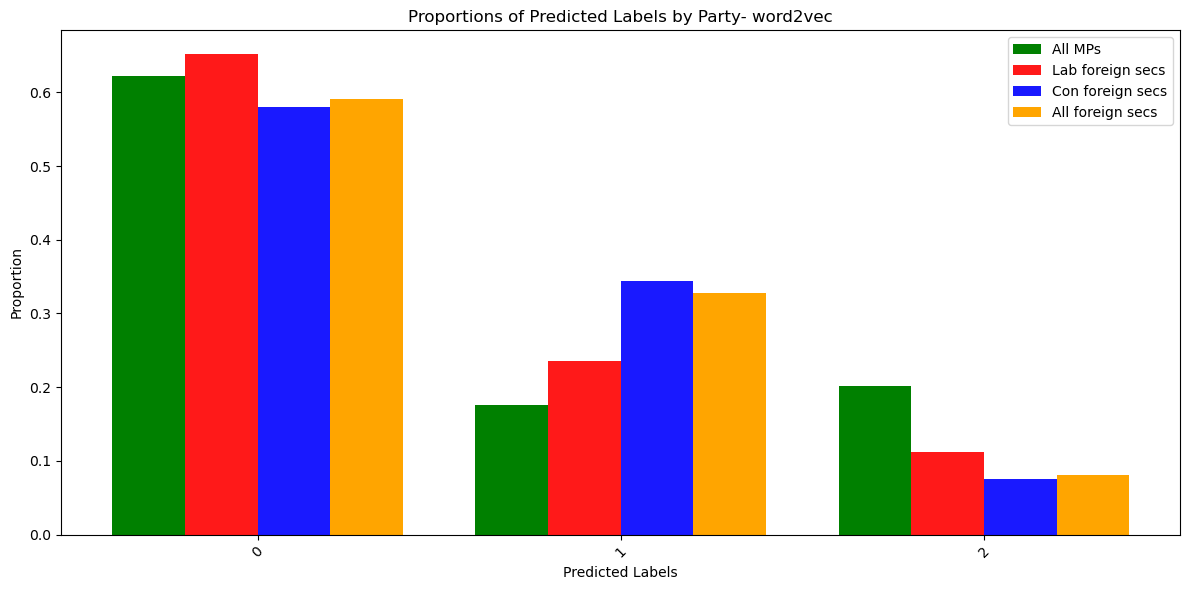

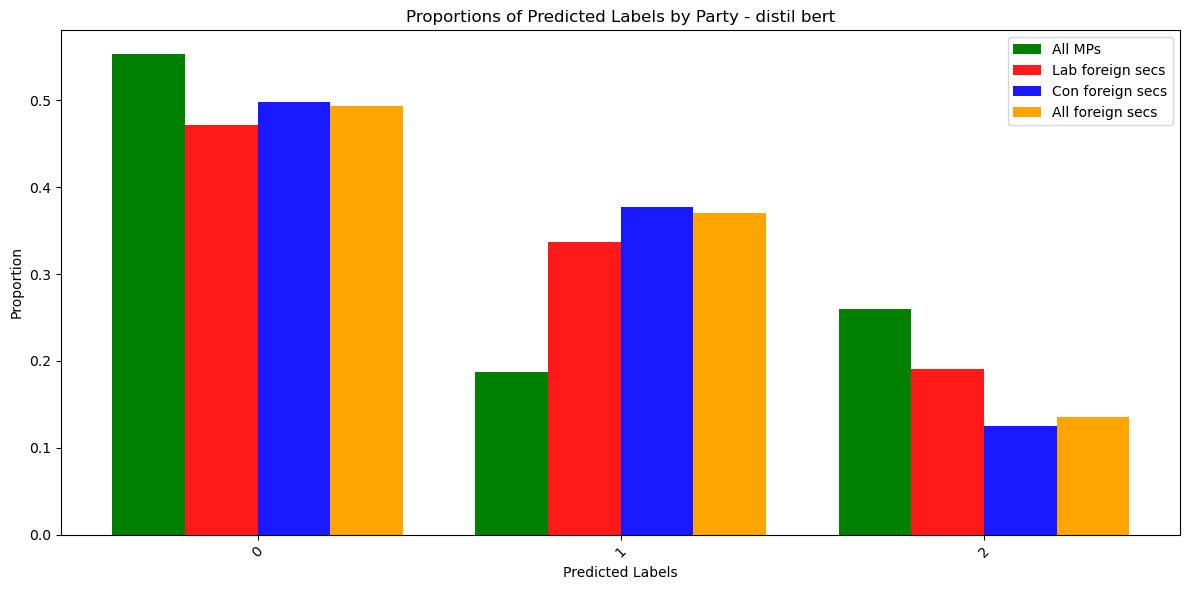

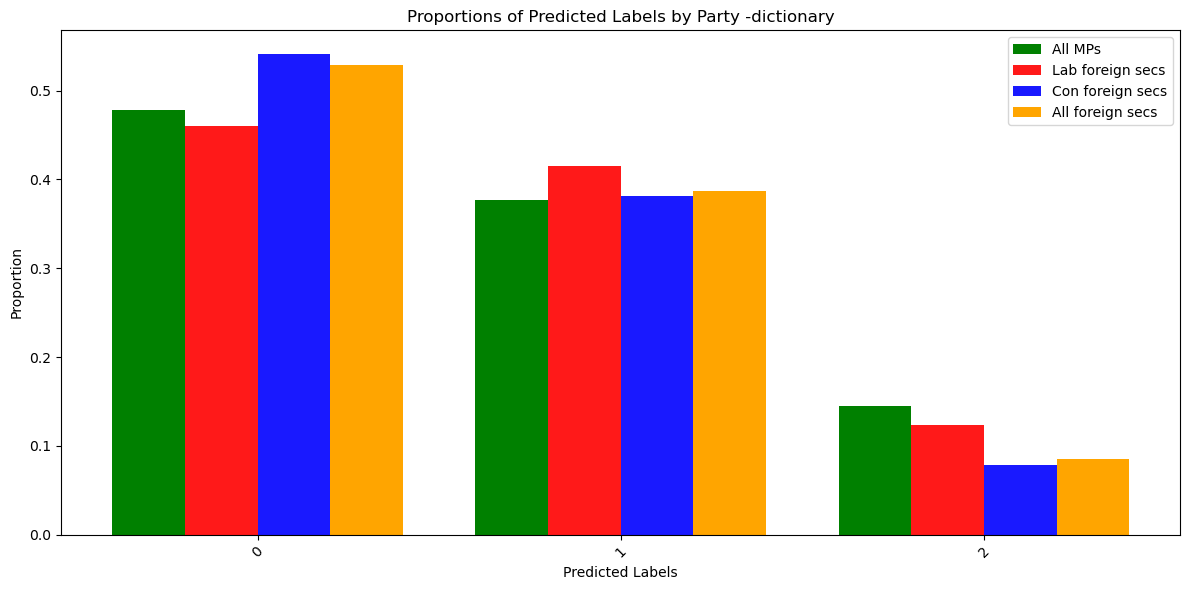

In [59]:
# Here I am finding the total number of referencnes in the DataFrame - using sentences is an error carried through from when I thought I might use sentences however the name of the variables does not impact the analysis.
total_sentences = len(df3)

# Here I am finding the proportions of each moral sentiment categrory 
proportions = df3['moral_embeddings'].value_counts(normalize=True).sort_index()

# Here I am finding the proportions for Lab and Con separately
lab_df = filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Lab']
con_df = filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Con']

proportions_lab = lab_df['moral_embeddings'].value_counts(normalize=True).sort_index()
proportions_con = con_df['moral_embeddings'].value_counts(normalize=True).sort_index()
proportions2 = filtered_sentences_df1['moral_embeddings'].value_counts(normalize=True).sort_index()


# This will plto the bar graph for all proportions
plt.figure(figsize=(12, 6))

x = np.arange(len(proportions.index))
width = 0.2 
plt.bar(x - width, proportions, width=width, color='green', label='All MPs')
plt.bar(x, proportions_lab, width=width, color='red', alpha=0.9, label='Lab foreign secs')
plt.bar(x + width, proportions_con, width=width, color='blue', alpha=0.9, label='Con foreign secs')
plt.bar(x + 2*width, proportions2, width=width, color='orange', label='All foreign secs')
plt.xlabel('Predicted Labels')
plt.ylabel('Proportion')
plt.title('Proportions of Predicted Labels by Party- word2vec')
plt.xticks(ticks=x + width/2, labels=proportions.index, rotation=45) 
plt.legend()
plt.tight_layout()

plt.show()

# This code for the plotting the bar chart of the BERT model for moral sentiment categories.

import matplotlib.pyplot as plt
# Here I am calcuating the total number of references in the DataFrame
total_sentences = len(df2)

# Here I am finding the proportions of each moral sentiment category
proportions = df2['predicted_labels2'].value_counts(normalize=True).sort_index()

# here i am finding the proportions for Lab and Con separately
lab_df = filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Lab']
con_df = filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Con']

proportions_lab = lab_df['predicted_labels2'].value_counts(normalize=True).sort_index()
proportions_con = con_df['predicted_labels2'].value_counts(normalize=True).sort_index()
proportions2 = filtered_sentences_df1['predicted_labels2'].value_counts(normalize=True).sort_index()


# The follow section of code plots the the bar graph for all proportions
plt.figure(figsize=(12, 6))

x = np.arange(len(proportions.index))
width = 0.2  
plt.bar(x - width, proportions, width=width, color='green', label='All MPs')
plt.bar(x, proportions_lab, width=width, color='red', alpha=0.9, label='Lab foreign secs')
plt.bar(x + width, proportions_con, width=width, color='blue', alpha=0.9, label='Con foreign secs')
plt.bar(x + 2*width, proportions2, width=width, color='orange', label='All foreign secs')

plt.xlabel('Predicted Labels')
plt.ylabel('Proportion')
plt.title('Proportions of Predicted Labels by Party - distil bert')
plt.xticks(ticks=x + width/2, labels=proportions.index, rotation=45)  
plt.legend()
plt.tight_layout()

plt.show()

#This last bar graph for this section plots the proportions for moral sentiment for the customised dictionary 
total_sentences = len(df2)

#Here I am calculate the proportions of each moral sentiment category. 
proportions = df2['moral_sentiment'].value_counts(normalize=True).sort_index()

# Here I am calculating the proportions for Lab and Con separately
lab_df = filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Lab']
con_df = filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Con']

proportions_lab = lab_df['moral_sentiment'].value_counts(normalize=True).sort_index()
proportions_con = con_df['moral_sentiment'].value_counts(normalize=True).sort_index()
proportions2 = filtered_sentences_df1['moral_sentiment'].value_counts(normalize=True).sort_index()


#The folowing code plots the bar graph - in the same manner as the previous two bar graphs.
plt.figure(figsize=(12, 6))

x = np.arange(len(proportions.index))
width = 0.2  
plt.bar(x - width, proportions, width=width, color='green', label='All MPs')
plt.bar(x, proportions_lab, width=width, color='red', alpha=0.9, label='Lab foreign secs')
plt.bar(x + width, proportions_con, width=width, color='blue', alpha=0.9, label='Con foreign secs')
plt.bar(x + 2*width, proportions2, width=width, color='orange', label='All foreign secs')

plt.xlabel('Predicted Labels')
plt.ylabel('Proportion')
plt.title('Proportions of Predicted Labels by Party -dictionary')
plt.xticks(ticks=x + width/2, labels=proportions.index, rotation=45) 
plt.legend()
plt.tight_layout()

plt.show()

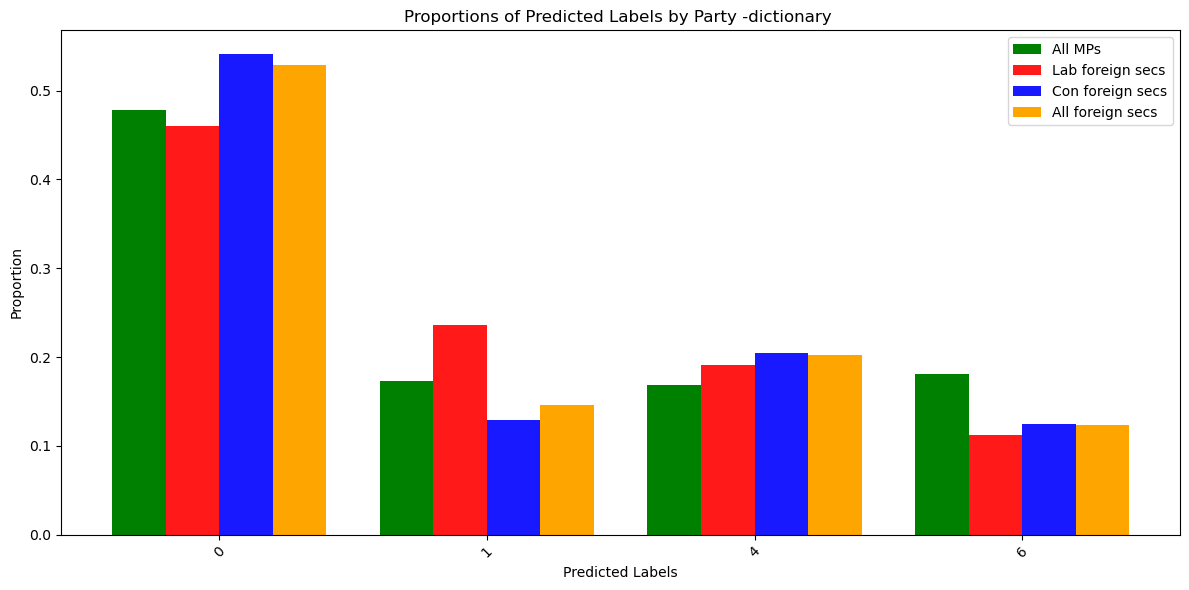

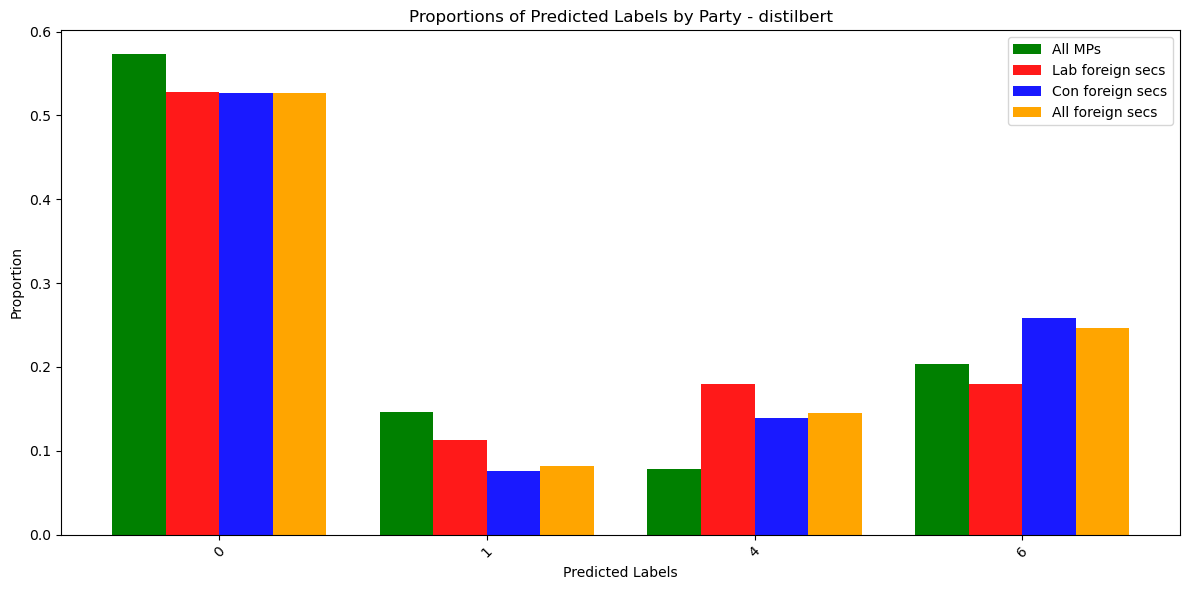

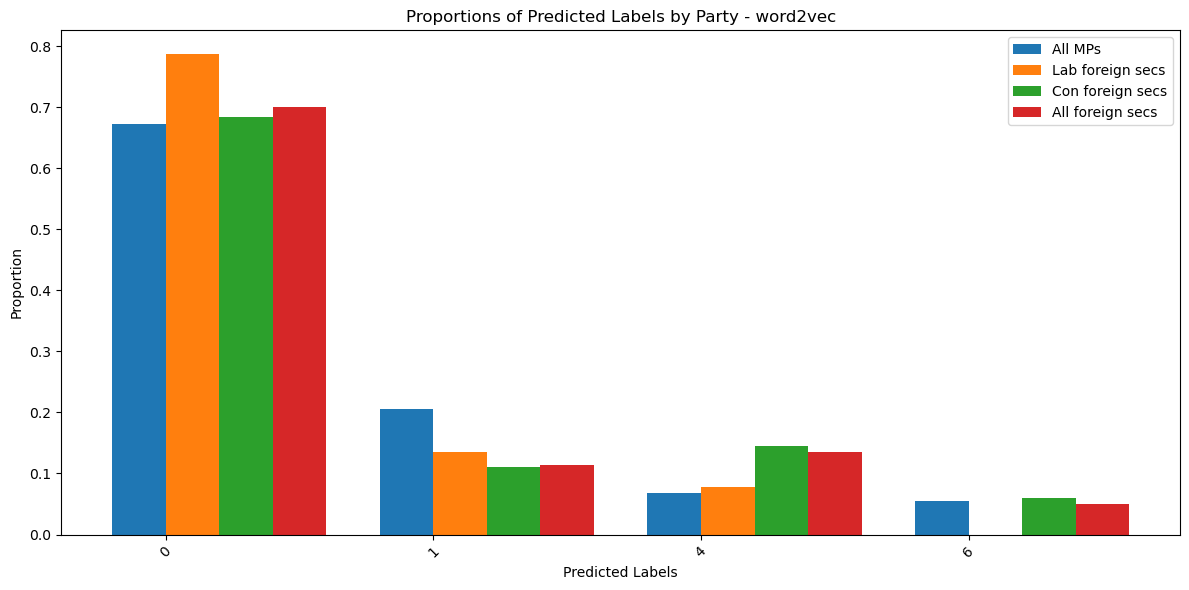

In [64]:
#code for the ploting the bar chart of the customised dictionary, bert and word2vec for moral foundations.

import matplotlib.pyplot as plt
# HEre I am calculating the total number of references in the dataframe
total_sentences = len(df2)

# Here I am finding the proportions of each moral foundation category for the customised dictionary 
proportions = df2['recoded'].value_counts(normalize=True).sort_index()

# here I am calculating the proportions for Lab and Con separately
lab_df = filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Lab']
con_df = filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Con']

proportions_lab = lab_df['recoded'].value_counts(normalize=True).sort_index()
proportions_con = con_df['recoded'].value_counts(normalize=True).sort_index()
proportions2 = filtered_sentences_df1['recoded'].value_counts(normalize=True).sort_index()


# This code plots the bar graph of proportions for each category. 
plt.figure(figsize=(12, 6))

x = np.arange(len(proportions.index))
width = 0.2  
plt.bar(x - width, proportions, width=width, color='green', label='All MPs')
plt.bar(x, proportions_lab, width=width, color='red', alpha=0.9, label='Lab foreign secs')
plt.bar(x + width, proportions_con, width=width, color='blue', alpha=0.9, label='Con foreign secs')
plt.bar(x + 2*width, proportions2, width=width, color='orange', label='All foreign secs')

plt.xlabel('Predicted Labels')
plt.ylabel('Proportion')
plt.title('Proportions of Predicted Labels by Party -dictionary ')
plt.xticks(ticks=x + width/2, labels=proportions.index, rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

# Here I am calculating the proportions of each category in the 'predicted_label' column for BERT model and moral foundations.
proportions = df2['predicted_labels'].value_counts(normalize=True).sort_index()

# here I am the proportions for Lab and Con separately
lab_df = filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Lab']
con_df = filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Con']

proportions_lab = lab_df['predicted_labels'].value_counts(normalize=True).sort_index()
proportions_con = con_df['predicted_labels'].value_counts(normalize=True).sort_index()
proportions2 = filtered_sentences_df1['predicted_labels'].value_counts(normalize=True).sort_index()


# This code plots the graph for the BERT model.
plt.figure(figsize=(12, 6))

x = np.arange(len(proportions.index))
width = 0.2  
plt.bar(x - width, proportions, width=width, color='green', label='All MPs')
plt.bar(x, proportions_lab, width=width, color='red', alpha=0.9, label='Lab foreign secs')
plt.bar(x + width, proportions_con, width=width, color='blue', alpha=0.9, label='Con foreign secs')
plt.bar(x + 2*width, proportions2, width=width, color='orange', label='All foreign secs')

plt.xlabel('Predicted Labels')
plt.ylabel('Proportion')
plt.title('Proportions of Predicted Labels by Party - distilbert')
plt.xticks(ticks=x + width/2, labels=proportions.index, rotation=45) 
plt.legend()
plt.tight_layout()

plt.show()

proportions3 = df3['moral_embeddings2'].value_counts(normalize=True).sort_index()
# Here Iam finding the proportions for Lab and Con separately
lab_df = filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Lab']
con_df = filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Con']

proportions_lab = lab_df['moral_embeddings2'].value_counts(normalize=True).sort_index()
proportions_con = con_df['moral_embeddings2'].value_counts(normalize=True).sort_index()
proportions4 = filtered_sentences_df1['moral_embeddings2'].value_counts(normalize=True).sort_index()

# As the word embedding model use a different dataframe this is calculated differently, and the 
#labels for the bars need to be reassigned and indexed.
combined_proportions = pd.DataFrame({
    'All MPs': proportions3.reindex(proportions4.index, fill_value=0),
    'Lab foreign secs': proportions_lab.reindex(proportions4.index, fill_value=0),
    'Con foreign secs': proportions_con.reindex(proportions4.index, fill_value=0),
    'All foreign secs': proportions4
})

#now the same code as above can be re-used again and the proprotions for each moral foundation and group are plotted.
plt.figure(figsize=(12, 6))

x = np.arange(len(proportions4.index))
width = 0.2 
for i, (col_name, data) in enumerate(combined_proportions.items()):
    plt.bar(x + i * width, data, width=width, label=col_name)

plt.xlabel('Predicted Labels')
plt.ylabel('Proportion')
plt.title('Proportions of Predicted Labels by Party - word2vec')
plt.xticks(ticks=x + width/2, labels=proportions4.index, rotation=45) 
plt.legend()
plt.tight_layout()

plt.show()

This section of the code plots all the bar chart for comparing the labout and conservative Mps across the whole dataset, again much of the above code is simply recycled, and a few dataframes and labels changed each time. 

Moral Foundation 0
Proportion of Conservative Texts: 0.6322209758833427
Proportion of Labour Texts: 0.6341226078494973
Moral Foundation 1
Proportion of Conservative Texts: 0.19223219293325855
Proportion of Labour Texts: 0.16509892961401232
Moral Foundation 2
Proportion of Conservative Texts: 0.17554683118339875
Proportion of Labour Texts: 0.20077846253649043


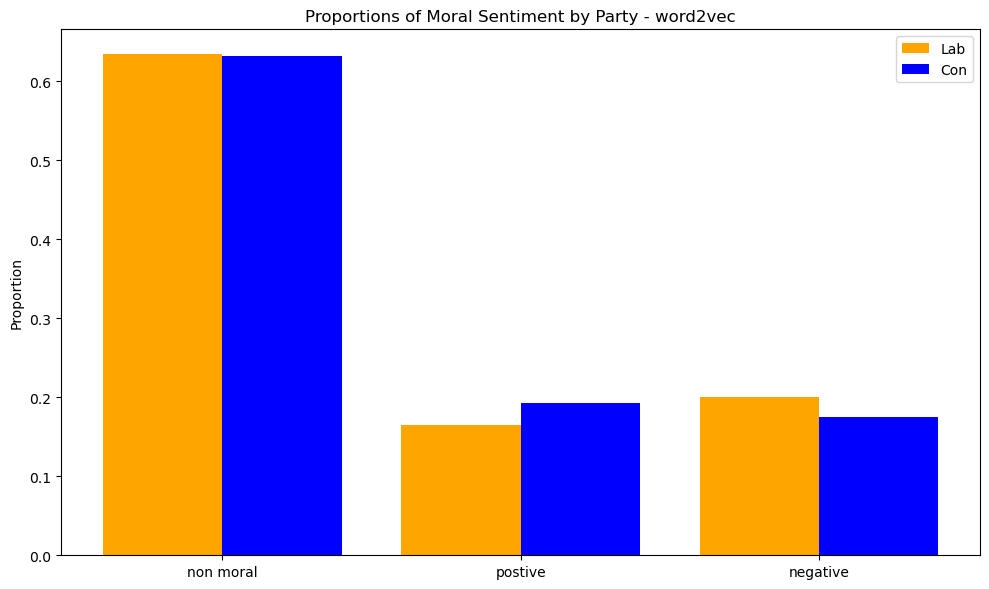

In [83]:
#This code is for plotting the bar chanrt for the word2vec moral for moral sentiment.

# Here i am finding the total number of texts for conservative and labour MPs
total_texts_con = len(df3[df3['party2'] == 'Con'])
total_texts_lab = len(df3[df3['party2'] == 'Lab'])

proportions_conservative = {0: 0.0, 1: 0.0, 2: 0.0}
proportions_labour = {0: 0.0, 1: 0.0, 2: 0.0}

for foundation in [0, 1, 2]:
    foundation_texts_con = df3[(df3['moral_embeddings'] == foundation) & (df3['party2'] == 'Con')]
    foundation_texts_lab = df3[(df3['moral_embeddings'] == foundation) & (df3['party2'] == 'Lab')]

    proportion_con = len(foundation_texts_con) / total_texts_con if total_texts_con > 0 else 0.0
    proportion_lab = len(foundation_texts_lab) / total_texts_lab if total_texts_lab > 0 else 0.0

    proportions_conservative[foundation] = proportion_con
    proportions_labour[foundation] = proportion_lab

# Here I am printing the proportions for each moral foundation separately for conservative and labour Mps
for foundation in [0, 1, 2]:
    print(f"Moral Foundation {foundation}")
    print(f"Proportion of Conservative Texts: {proportions_conservative[foundation]}")
    print(f"Proportion of Labour Texts: {proportions_labour[foundation]}")

relevant_columns = ['recoded', 'party2']

#Herw I am creating the labels for the bars of the graph
foundation_labels = {
    0: 'non moral',
    1: 'postive',
    2: 'negative',
  
}

# Here I am retreiving the Proportions for 'Lab' and 'Con'
proportions_lab = [proportions_labour[f] for f in [0, 1, 2]]
proportions_con = [proportions_conservative[f] for f in [0, 1, 2]]

# This code plots the bar graph.
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.4
color_lab = 'orange'
color_con = 'blue'

ax.bar([x - width/2 for x in range(len(proportions_lab))], proportions_lab, width, label='Lab', color=color_lab)
ax.bar([x + width/2 for x in range(len(proportions_con))], proportions_con, width, label='Con', color=color_con)
ax.set_ylabel('Proportion')
ax.set_title('Proportions of Moral Sentiment by Party - word2vec')
ax.set_xticks(range(len(foundation_labels)))
ax.set_xticklabels([foundation_labels[f] for f in [0, 1, 2]])
ax.legend()

plt.tight_layout()
plt.show()

Moral Foundation 0
Proportion of Conservative Texts: 0.5614133482893999
Proportion of Labour Texts: 0.5643853389555628
Moral Foundation 1
Proportion of Conservative Texts: 0.20204711160964667
Proportion of Labour Texts: 0.17401881284463186
Moral Foundation 2
Proportion of Conservative Texts: 0.23653954010095346
Proportion of Labour Texts: 0.26159584819980536


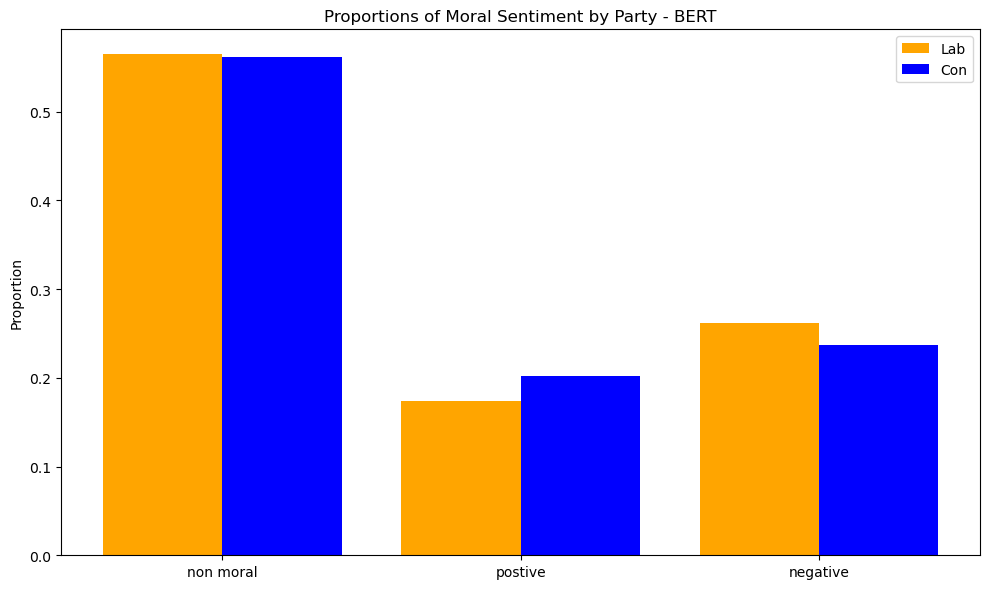

In [82]:
#this code plots the bar graph for moral sentiment for the BERT model. - for comparing all Labour and con MPs


# Here i am finding the total number of texts for conservative and labour MPs
total_texts_con = len(df2[df2['party2'] == 'Con'])
total_texts_lab = len(df2[df2['party2'] == 'Lab'])

proportions_conservative = {0: 0.0, 1: 0.0, 2: 0.0}
proportions_labour = {0: 0.0, 1: 0.0, 2: 0.0}

for foundation in [0, 1, 2]:
    foundation_texts_con = df2[(df2['predicted_labels2'] == foundation) & (df2['party2'] == 'Con')]
    foundation_texts_lab = df2[(df2['predicted_labels2'] == foundation) & (df2['party2'] == 'Lab')]

    proportion_con = len(foundation_texts_con) / total_texts_con if total_texts_con > 0 else 0.0
    proportion_lab = len(foundation_texts_lab) / total_texts_lab if total_texts_lab > 0 else 0.0

    proportions_conservative[foundation] = proportion_con
    proportions_labour[foundation] = proportion_lab

# Here i am finding the proportions for each moral foundation separately for conservative and labour Mps
for foundation in [0, 1, 2]:
    print(f"Moral Foundation {foundation}")
    print(f"Proportion of Conservative Texts: {proportions_conservative[foundation]}")
    print(f"Proportion of Labour Texts: {proportions_labour[foundation]}")

relevant_columns = ['recoded', 'party2']

#Here i am assinging each of the categories a label for the bar chart.
foundation_labels = {
    0: 'non moral',
    1: 'postive',
    2: 'negative',
  
}

# here i am finding/retevieing the proportions for 'Lab' and 'Con' for the bar chart
proportions_lab = [proportions_labour[f] for f in [0, 1, 2]]
proportions_con = [proportions_conservative[f] for f in [0, 1, 2]]

# This code plots the bar graph.
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.4

color_lab = 'orange'
color_con = 'blue'

ax.bar([x - width/2 for x in range(len(proportions_lab))], proportions_lab, width, label='Lab', color=color_lab)
ax.bar([x + width/2 for x in range(len(proportions_con))], proportions_con, width, label='Con', color=color_con)
ax.set_ylabel('Proportion')
ax.set_title('Proportions of Moral Sentiment by Party - BERT')
ax.set_xticks(range(len(foundation_labels)))
ax.set_xticklabels([foundation_labels[f] for f in [0, 1, 2]])
ax.legend()

plt.tight_layout()
plt.show()

Moral Foundation 0
Proportion of Conservative Texts: 0.4847167694896242
Proportion of Labour Texts: 0.48102497567304575
Moral Foundation 1
Proportion of Conservative Texts: 0.38278182837913627
Proportion of Labour Texts: 0.3712293220888745
Moral Foundation 2
Proportion of Conservative Texts: 0.13250140213123948
Proportion of Labour Texts: 0.14774570223807978


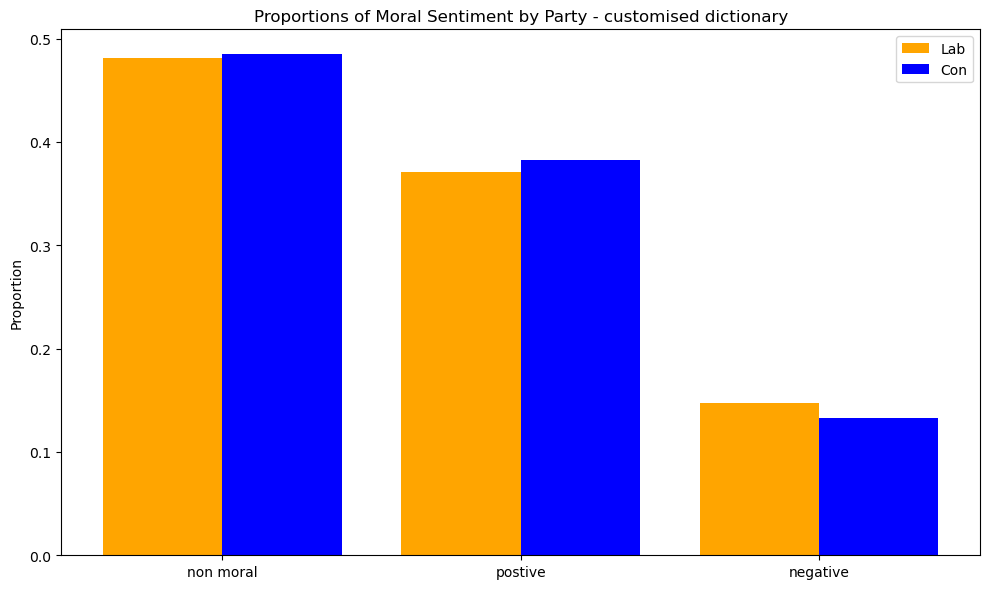

In [65]:
#this code plots the bar graph for moral sentiment for the customised dictionary model. - for comparing all Labour and con MPs


# here I am finding the total number of texts for conservative and labour MPs
total_texts_con = len(df2[df2['party2'] == 'Con'])
total_texts_lab = len(df2[df2['party2'] == 'Lab'])


# this section here sets up the empty proportions for the conservative and labour moral sentiment categories
proportions_conservative = {0: 0.0, 1: 0.0, 2: 0.0}
proportions_labour = {0: 0.0, 1: 0.0, 2: 0.0}


#this loops through each of the proportion labels and calculates the proportions by party.
for foundation in [0, 1, 2]:
    foundation_texts_con = df2[(df2['moral_sentiment'] == foundation) & (df2['party2'] == 'Con')]
    foundation_texts_lab = df2[(df2['moral_sentiment'] == foundation) & (df2['party2'] == 'Lab')]

    proportion_con = len(foundation_texts_con) / total_texts_con if total_texts_con > 0 else 0.0
    proportion_lab = len(foundation_texts_lab) / total_texts_lab if total_texts_lab > 0 else 0.0

    proportions_conservative[foundation] = proportion_con
    proportions_labour[foundation] = proportion_lab

 #Here i am finding the proportions for each moral foundation separately for conservative and labour Mps
for foundation in [0, 1, 2]:
    print(f"Moral Foundation {foundation}")
    print(f"Proportion of Conservative Texts: {proportions_conservative[foundation]}")
    print(f"Proportion of Labour Texts: {proportions_labour[foundation]}")

relevant_columns = ['recoded', 'party2']


foundation_labels = {
    0: 'non moral',
    1: 'postive',
    2: 'negative',
  
}

# here i am finding/retevieing the proportions for 'Lab' and 'Con' for the bar chart
proportions_lab = [proportions_labour[f] for f in [0, 1, 2]]
proportions_con = [proportions_conservative[f] for f in [0, 1, 2]]

#This code plots the bar chart for the moral sentiment categories
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.4
color_lab = 'orange'
color_con = 'blue'

ax.bar([x - width/2 for x in range(len(proportions_lab))], proportions_lab, width, label='Lab', color=color_lab)
ax.bar([x + width/2 for x in range(len(proportions_con))], proportions_con, width, label='Con', color=color_con)


ax.set_ylabel('Proportion')
ax.set_title('Proportions of Moral Sentiment by Party - customised dictionary')
ax.set_xticks(range(len(foundation_labels)))
ax.set_xticklabels([foundation_labels[f] for f in [0, 1, 2]])
ax.legend()

plt.tight_layout()
plt.show()

Moral Foundation 0
Proportion of Conservative Texts: 0.4847167694896242
Proportion of Labour Texts: 0.48102497567304575
Moral Foundation 1
Proportion of Conservative Texts: 0.1690970274817723
Proportion of Labour Texts: 0.17158611741809926
Moral Foundation 4
Proportion of Conservative Texts: 0.17526640493550197
Proportion of Labour Texts: 0.16542328900421668
Moral Foundation 6
Proportion of Conservative Texts: 0.1709197980931015
Proportion of Labour Texts: 0.18196561790463833


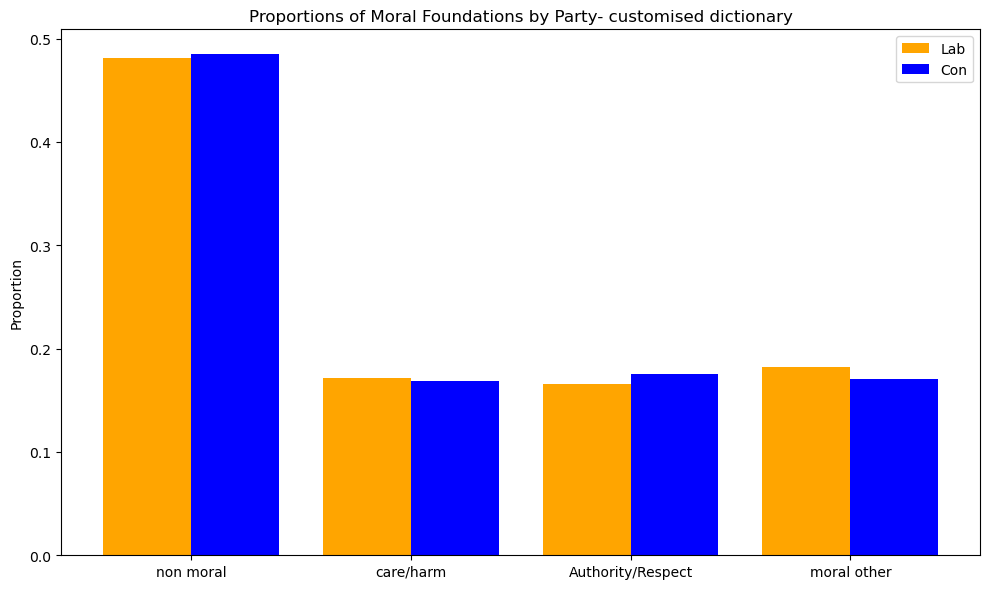

In [74]:
#this code plots the bar chat for the customised dictionary model for moral foundations

# Here i am finding the total number of texts for conservative and labour MPs
total_texts_con = len(df2[df2['party2'] == 'Con'])
total_texts_lab = len(df2[df2['party2'] == 'Lab'])

for foundation in [0, 1, 4, 6]:
    foundation_texts_con = df2[(df2['recoded'] == foundation) & (df2['party2'] == 'Con')]
    foundation_texts_lab = df2[(df2['recoded'] == foundation) & (df2['party2'] == 'Lab')]

    proportion_con = len(foundation_texts_con) / total_texts_con if total_texts_con > 0 else 0.0
    proportion_lab = len(foundation_texts_lab) / total_texts_lab if total_texts_lab > 0 else 0.0

    proportions_conservative[foundation] = proportion_con
    proportions_labour[foundation] = proportion_lab

# Here i am finding the proportions for each moral foundation categrory for lab and con MPs
for foundation in [0, 1, 4, 6]:
    print(f"Moral Foundation {foundation}")
    print(f"Proportion of Conservative Texts: {proportions_conservative[foundation]}")
    print(f"Proportion of Labour Texts: {proportions_labour[foundation]}")
    
# here i am assigning labels to the bars for each moral foundation column
foundation_labels = {
    0: 'non moral',
    1: 'care/harm',
    4: 'Authority/Respect',
    6: 'moral other'
}

proportions_lab = [proportions_labour[f] for f in [0, 1, 4, 6]]
proportions_con = [proportions_conservative[f] for f in [0, 1, 4, 6]]

# This code plots the graph.
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.4

color_lab = 'orange'
color_con = 'blue'

ax.bar([x - width/2 for x in range(len(proportions_lab))], proportions_lab, width, label='Lab', color=color_lab)
ax.bar([x + width/2 for x in range(len(proportions_con))], proportions_con, width, label='Con', color=color_con)
ax.set_ylabel('Proportion')
ax.set_title('Proportions of Moral Foundations by Party- customised dictionary')
ax.set_xticks(range(len(foundation_labels)))
ax.set_xticklabels([foundation_labels[f] for f in [0, 1, 4, 6]])
ax.legend()

plt.tight_layout()
plt.show()

Moral Foundation 0
Proportion of Conservative Texts: 0.5806225462703309
Proportion of Labour Texts: 0.5890366526110931
Moral Foundation 1
Proportion of Conservative Texts: 0.12913628715647785
Proportion of Labour Texts: 0.1482322413233863
Moral Foundation 4
Proportion of Conservative Texts: 0.08356702187324734
Proportion of Labour Texts: 0.06860201102821926
Moral Foundation 6
Proportion of Conservative Texts: 0.2066741446999439
Proportion of Labour Texts: 0.19412909503730133


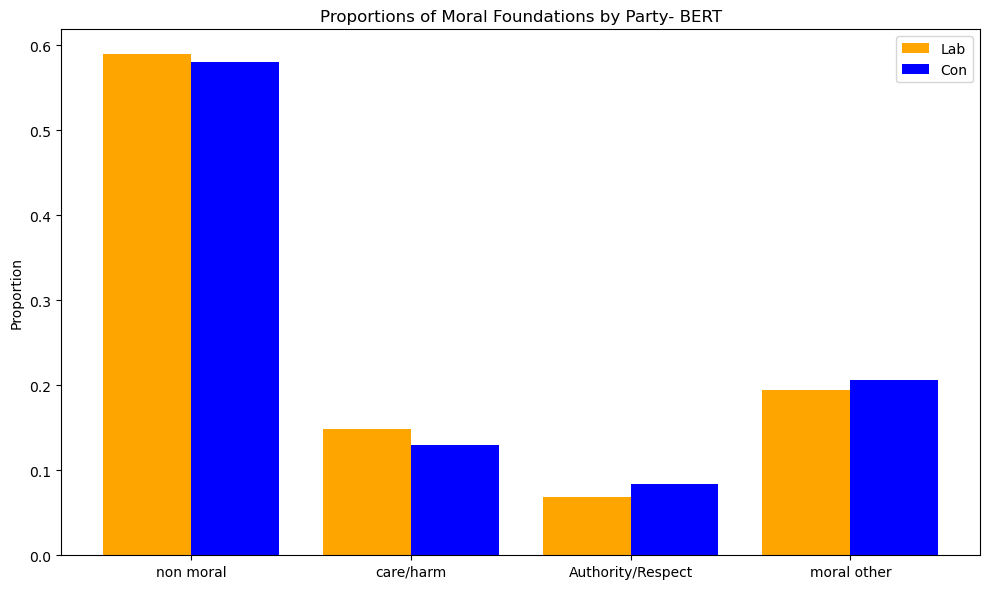

In [87]:
#this code plots the bar chat for the BERT model for moral foundations

# Here  iam finding the total number of texts for conservative and labour MPs
total_texts_con = len(df2[df2['party2'] == 'Con'])
total_texts_lab = len(df2[df2['party2'] == 'Lab'])

for foundation in [0, 1, 4, 6]:
    foundation_texts_con = df2[(df2['predicted_labels'] == foundation) & (df2['party2'] == 'Con')]
    foundation_texts_lab = df2[(df2['predicted_labels'] == foundation) & (df2['party2'] == 'Lab')]

    proportion_con = len(foundation_texts_con) / total_texts_con if total_texts_con > 0 else 0.0
    proportion_lab = len(foundation_texts_lab) / total_texts_lab if total_texts_lab > 0 else 0.0

    proportions_conservative[foundation] = proportion_con
    proportions_labour[foundation] = proportion_lab

# Here i am finding the proportions for each moral foundation separately for conservative and labour Mps
for foundation in [0, 1, 4, 6]:
    print(f"Moral Foundation {foundation}")
    print(f"Proportion of Conservative Texts: {proportions_conservative[foundation]}")
    print(f"Proportion of Labour Texts: {proportions_labour[foundation]}")
    
#Here I am assigning the moral foundations labels for the bars of the bar chart
foundation_labels = {
    0: 'non moral',
    1: 'care/harm',
    4: 'Authority/Respect',
    6: 'moral other'
}

proportions_lab = [proportions_labour[f] for f in [0, 1, 4, 6]]
proportions_con = [proportions_conservative[f] for f in [0, 1, 4, 6]]

#This code plots the bar graph.
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.4
color_lab = 'orange'
color_con = 'blue'

ax.bar([x - width/2 for x in range(len(proportions_lab))], proportions_lab, width, label='Lab', color=color_lab)
ax.bar([x + width/2 for x in range(len(proportions_con))], proportions_con, width, label='Con', color=color_con)
ax.set_ylabel('Proportion')
ax.set_title('Proportions of Moral Foundations by Party- BERT')
ax.set_xticks(range(len(foundation_labels)))
ax.set_xticklabels([foundation_labels[f] for f in [0, 1, 4, 6]])
ax.legend()

plt.tight_layout()
plt.show()

Moral Foundation 0
Proportion of Conservative Texts: 0.6852215367358385
Proportion of Labour Texts: 0.6827765163801492
Moral Foundation 1
Proportion of Conservative Texts: 0.18648345485137408
Proportion of Labour Texts: 0.20467077521894259
Moral Foundation 4
Proportion of Conservative Texts: 0.0720695457094784
Proportion of Labour Texts: 0.05984430749270191
Moral Foundation 6
Proportion of Conservative Texts: 0.05622546270330903
Proportion of Labour Texts: 0.05270840090820629


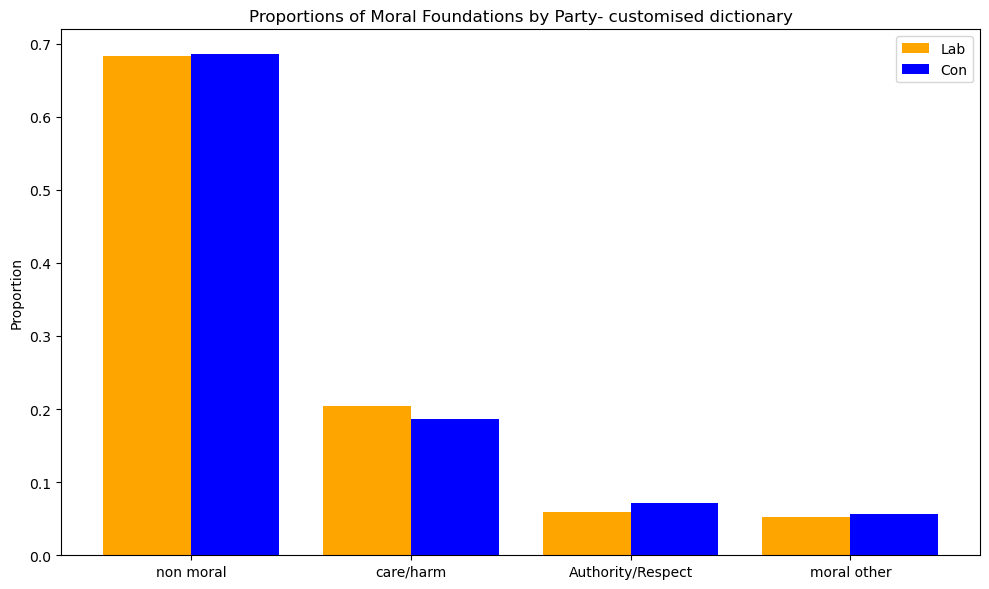

In [76]:
#this code plots the bar chat for the wrod2vec model for moral foundations

# Here i am calculating the total number of texts for conservative and labour MPs
total_texts_con = len(df3[df3['party2'] == 'Con'])
total_texts_lab = len(df3[df3['party2'] == 'Lab'])

for foundation in [0, 1, 4, 6]:
    foundation_texts_con = df3[(df3['moral_embeddings2'] == foundation) & (df3['party2'] == 'Con')]
    foundation_texts_lab = df3[(df3['moral_embeddings2'] == foundation) & (df3['party2'] == 'Lab')]

    proportion_con = len(foundation_texts_con) / total_texts_con if total_texts_con > 0 else 0.0
    proportion_lab = len(foundation_texts_lab) / total_texts_lab if total_texts_lab > 0 else 0.0

    proportions_conservative[foundation] = proportion_con
    proportions_labour[foundation] = proportion_lab

# Here i am finding the proportions for each moral foundation separately for conservative and labour Mps
for foundation in [0, 1, 4, 6]:
    print(f"Moral Foundation {foundation}")
    print(f"Proportion of Conservative Texts: {proportions_conservative[foundation]}")
    print(f"Proportion of Labour Texts: {proportions_labour[foundation]}")
    
# here I am assigning the bar labels for each moral foundation
foundation_labels = {
    0: 'non moral',
    1: 'care/harm',
    4: 'Authority/Respect',
    6: 'moral other'
}

proportions_lab = [proportions_labour[f] for f in [0, 1, 4, 6]]
proportions_con = [proportions_conservative[f] for f in [0, 1, 4, 6]]

#This code plots the bar graph.
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.4
color_lab = 'orange'
color_con = 'blue'

ax.bar([x - width/2 for x in range(len(proportions_lab))], proportions_lab, width, label='Lab', color=color_lab)
ax.bar([x + width/2 for x in range(len(proportions_con))], proportions_con, width, label='Con', color=color_con)
ax.set_ylabel('Proportion')
ax.set_title('Proportions of Moral Foundations by Party- customised dictionary')
ax.set_xticks(range(len(foundation_labels)))
ax.set_xticklabels([foundation_labels[f] for f in [0, 1, 4, 6]])
ax.legend()

plt.tight_layout()
plt.show()

GETTING THE SUMMARY STATS FOR THE FOREIGN SECRETARIES DATASET using this code: https://pythonnumericalmethods.berkeley.edu/notebooks/chapter05.01-For-Loops.html and this code: https://stackoverflow.com/questions/38530130/group-by-count-and-calculate-proportions-in-pandas

In [86]:
for mp, year_range in foreign_secretary_tenures.items():
    start_year, end_year = year_range[0], year_range[1]
    mp_sentences = filtered_df[(filtered_df['speaker2'] == mp) & (filtered_df['Year'] >= start_year) & (filtered_df['Year'] <= end_year)]
    filtered_sentences_df1 = pd.concat([filtered_sentences_df1, mp_sentences])

sentences_per_foreign_secretary = filtered_sentences_df1.groupby('speaker2').size().reset_index(name='Number_of_references')

grouped_by_speaker = filtered_sentences_df1.groupby('speaker2')
average_words_per_reference = grouped_by_speaker['Reference to China'].apply(lambda x: np.mean([len(reference.split()) for reference in x]))

summary_df = pd.DataFrame({
    'Foreign_Secretary': average_words_per_reference.index,
    'Average_Words_per_Reference': average_words_per_reference.values
})

print("Summary Statistics for Average Words in References to China:")
print(summary_df)

overall_average_words = average_words_per_reference.mean()
print(f"Overall Average Words per Reference to China: {overall_average_words:.2f}")
labour_subset = filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Lab']
conservative_subset = filtered_sentences_df1[filtered_sentences_df1['party2'] == 'Con']
labour_average_words = labour_subset['Reference to China'].apply(lambda x: len(x.split())).mean()
conservative_average_words = conservative_subset['Reference to China'].apply(lambda x: len(x.split())).mean()

print(f"Average Words per Reference to China for Labour: {labour_average_words:.2f}")
print(f"Average Words per Reference to China for Conservative: {conservative_average_words:.2f}")

john_major_sentences = filtered_df[(filtered_df['speaker2'] == 'John Major') & (filtered_df['Year'] == 1989)]
john_major_count = len(john_major_sentences)
print("Number of sentences spoken by John Major in 1989:", john_major_count)


Summary Statistics for Average Words in References to China:
   Foreign_Secretary  Average_Words_per_Reference
0      Boris Johnson                    67.428571
1     David Miliband                    86.523810
2       Dominic Raab                    77.802817
3       Douglas Hurd                    69.766467
4    Elizabeth Truss                    70.500000
5      Geoffrey Howe                    77.092105
6         Jack Straw                    84.275000
7     James Cleverly                    74.250000
8        Jeremy Hunt                    68.750000
9    Malcolm Rifkind                    77.957447
10  Margaret Beckett                    83.727273
11    Philip Hammond                    71.866667
12        Robin Cook                    79.529412
13     William Hague                    75.371795
Overall Average Words per Reference to China: 76.06
Average Words per Reference to China for Labour: 83.83
Average Words per Reference to China for Conservative: 73.82
Number of sentences s